In [1]:
# Imports: python modules
import sys, os, re, time
import timeit
from configparser import ConfigParser
# Science
import numpy as np
import scipy.stats as stats

In [2]:
# Imports: our own modules
# Add path
sys.path.append('../../bandits')
# Aux functions
from aux_functions import *
# Bandit modules
from bandits import *
from bandit_plotting import *
from bandit_environments import *
from bandit_reward_models import * 

# GP models
from gp_models import *

# Useful bandit execution for later use

In [3]:
def execute_bandit(bandit, environment, n_bandit_interactions):
    for t in np.arange(n_bandit_interactions):
        print('Bandit interaction t={}'.format(t))
        # Decide next arm
        a_t=bandit.next_action()

        # Play selected arm and observe reward
        y_t=environment.play(a_t)

        # Update history
        bandit.update_history(
                played_arm=a_t,
                observed_reward=y_t
                )
        
    return bandit

# Bandit

## Arm space

In [4]:
# n points
n_arm_points=100
a_points=torch.linspace(0,1,n_arm_points+1) # Equal spaced
# Dimensionality
d_arms=1
per_arm_meshgrid=torch.meshgrid([a_points]*d_arms)
a=torch.stack(per_arm_meshgrid, axis=-1).reshape(-1, d_arms) # n_points in dim==1

## True bandit reward model

In [5]:
true_bandit_environment=ContinuousLinearBernoulliBanditModel(
                slope=1,
                intercept=0
        )

In [6]:
optimal_arm = true_bandit_environment.optimal_arm(a)

## Our Bandit

### GP based bandit

In [7]:
# GP configuration
gp_config_filename='gp_config.ini'
# Based on config parser
gp_config = ConfigParser()
gp_config.read('../gp_configs/{}'.format(gp_config_filename))


['../gp_configs/gp_config.ini']

In [8]:
# GP model definition (without training input/output yet) from config
gp_model=ExactGPModel(
                a=None,
                y=None,
                mean_function=eval(gp_config.get('gp_model', 'mean_function')),
                kernel_function=eval(gp_config.get('gp_model', 'kernel_function')),
                likelihood=eval(gp_config.get('gp_model', 'llh_function')),
            )

In [9]:
# GP training options, from config
gp_training_options={
        'loss':eval(
                gp_config.get(
                        'training',
                        'loss',
                        fallback='gpytorch.mlls.ExactMarginalLogLikelihood()')
                   ),
        'n_train_max_iters':gp_config.getint(
                        'training',
                        'n_train_max_iters',
                        fallback=100),
        'loss_epsilon':gp_config.getfloat(
                        'training',
                        'loss_epsilon',
                        fallback=0.01),
        'optimizer':gp_config.get(
                        'training',
                        'optimizer',
                        fallback=torch.optim.Adam),
        'optimizer_params':cast_dict_values(
                            gp_config._sections['optimization_params'],
                            float
                            ),
    }

In [10]:
# Bandit reward model, from config
bandit_reward_model=GPRewardModel(
        gp_model=gp_model,
        likelihood_model=eval(
                            gp_config.get('gp_model', 'llh_function')
                            ),
        gp_training=gp_training_options,
        )

### Bandit algorithm: Thompson sampling

In [11]:
# Thompson sampling 
ts_algorithm={
    'name':'ThompsonSampling'
}

In [12]:
# Instantiate bandit class
ts_bandit=ContinuousArmBandit(
            arm_space=a,
            reward_model=bandit_reward_model,
            algorithm=ts_algorithm
            )

# One bandit execution

In [13]:
# Number of interactions
n_bandit_interactions=250

In [14]:
# Optimal reward can be pre-computed
optimal_expected_rewards = true_bandit_environment.mean(
                            optimal_arm*torch.ones((1,n_bandit_interactions))
                        )

In [15]:
# Execute bandit, for n_bandit_interaction
ts_bandit.restart(n_bandit_interactions)
ts_bandit = execute_bandit(ts_bandit, true_bandit_environment, n_bandit_interactions)

Bandit interaction t=0
GP reward model training started...
	Iteration 2/100 with loss=1.082
	Iteration 3/100 with loss=1.064
	Iteration 4/100 with loss=1.047
	Iteration 5/100 with loss=1.030
	Iteration 6/100 with loss=1.013


/usr/local/lib/python3.8/dist-packages/gpytorch/utils/cholesky.py:51: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


	Iteration 7/100 with loss=0.996
	Iteration 8/100 with loss=0.981
	Iteration 9/100 with loss=0.965
	Iteration 10/100 with loss=0.951
	Iteration 11/100 with loss=0.937
	Iteration 12/100 with loss=0.923
	Iteration 13/100 with loss=0.911
	Iteration 14/100 with loss=0.899
	Iteration 15/100 with loss=0.887
	Iteration 16/100 with loss=0.877
	Iteration 17/100 with loss=0.867
	Iteration 18/100 with loss=0.858
	Iteration 19/100 with loss=0.849
	Iteration 20/100 with loss=0.841
GP reward model updated after 19 iterations with loss=0.841
Bandit interaction t=1
GP reward model training started...
	Iteration 2/100 with loss=1.130
	Iteration 3/100 with loss=1.075
	Iteration 4/100 with loss=1.030
	Iteration 5/100 with loss=0.996
	Iteration 6/100 with loss=0.973
	Iteration 7/100 with loss=0.961
	Iteration 8/100 with loss=0.957
GP reward model updated after 7 iterations with loss=0.957
Bandit interaction t=2
GP reward model training started...
	Iteration 2/100 with loss=0.928
	Iteration 3/100 with loss

	Iteration 2/100 with loss=0.888
	Iteration 3/100 with loss=0.890
GP reward model updated after 2 iterations with loss=0.890
Bandit interaction t=43
GP reward model training started...
	Iteration 2/100 with loss=0.888
	Iteration 3/100 with loss=0.889
GP reward model updated after 2 iterations with loss=0.889
Bandit interaction t=44
GP reward model training started...
	Iteration 2/100 with loss=0.886
	Iteration 3/100 with loss=0.887
GP reward model updated after 2 iterations with loss=0.887
Bandit interaction t=45
GP reward model training started...
	Iteration 2/100 with loss=0.883
	Iteration 3/100 with loss=0.884
GP reward model updated after 2 iterations with loss=0.884
Bandit interaction t=46
GP reward model training started...
	Iteration 2/100 with loss=0.881
	Iteration 3/100 with loss=0.881
GP reward model updated after 2 iterations with loss=0.881
Bandit interaction t=47
GP reward model training started...
	Iteration 2/100 with loss=0.878
	Iteration 3/100 with loss=0.879
GP reward

GP reward model training started...
	Iteration 2/100 with loss=0.832
	Iteration 3/100 with loss=0.832
GP reward model updated after 2 iterations with loss=0.832
Bandit interaction t=88
GP reward model training started...
	Iteration 2/100 with loss=0.831
	Iteration 3/100 with loss=0.832
GP reward model updated after 2 iterations with loss=0.832
Bandit interaction t=89
GP reward model training started...
	Iteration 2/100 with loss=0.830
	Iteration 3/100 with loss=0.831
GP reward model updated after 2 iterations with loss=0.831
Bandit interaction t=90
GP reward model training started...
	Iteration 2/100 with loss=0.829
	Iteration 3/100 with loss=0.830
GP reward model updated after 2 iterations with loss=0.830
Bandit interaction t=91
GP reward model training started...
	Iteration 2/100 with loss=0.828
	Iteration 3/100 with loss=0.829
GP reward model updated after 2 iterations with loss=0.829
Bandit interaction t=92
GP reward model training started...
	Iteration 2/100 with loss=0.828
	Itera

	Iteration 2/100 with loss=0.804
	Iteration 3/100 with loss=0.804
GP reward model updated after 2 iterations with loss=0.804
Bandit interaction t=132
GP reward model training started...
	Iteration 2/100 with loss=0.803
	Iteration 3/100 with loss=0.803
GP reward model updated after 2 iterations with loss=0.803
Bandit interaction t=133
GP reward model training started...
	Iteration 2/100 with loss=0.803
	Iteration 3/100 with loss=0.803
GP reward model updated after 2 iterations with loss=0.803
Bandit interaction t=134
GP reward model training started...
	Iteration 2/100 with loss=0.802
	Iteration 3/100 with loss=0.802
GP reward model updated after 2 iterations with loss=0.802
Bandit interaction t=135
GP reward model training started...
	Iteration 2/100 with loss=0.802
	Iteration 3/100 with loss=0.802
GP reward model updated after 2 iterations with loss=0.802
Bandit interaction t=136
GP reward model training started...
	Iteration 2/100 with loss=0.801
	Iteration 3/100 with loss=0.802
GP r

	Iteration 3/100 with loss=0.791
GP reward model updated after 2 iterations with loss=0.791
Bandit interaction t=176
GP reward model training started...
	Iteration 2/100 with loss=0.790
	Iteration 3/100 with loss=0.790
GP reward model updated after 2 iterations with loss=0.790
Bandit interaction t=177
GP reward model training started...
	Iteration 2/100 with loss=0.790
	Iteration 3/100 with loss=0.790
GP reward model updated after 2 iterations with loss=0.790
Bandit interaction t=178
GP reward model training started...
	Iteration 2/100 with loss=0.790
	Iteration 3/100 with loss=0.790
GP reward model updated after 2 iterations with loss=0.790
Bandit interaction t=179
GP reward model training started...
	Iteration 2/100 with loss=0.790
	Iteration 3/100 with loss=0.790
GP reward model updated after 2 iterations with loss=0.790
Bandit interaction t=180
GP reward model training started...
	Iteration 2/100 with loss=0.789
	Iteration 3/100 with loss=0.789
GP reward model updated after 2 itera

/usr/local/lib/python3.8/dist-packages/gpytorch/utils/cholesky.py:51: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


GP reward model training started...
	Iteration 2/100 with loss=0.786
	Iteration 3/100 with loss=0.787
GP reward model updated after 2 iterations with loss=0.787
Bandit interaction t=203
GP reward model training started...
	Iteration 2/100 with loss=0.786
	Iteration 3/100 with loss=0.786
GP reward model updated after 2 iterations with loss=0.786
Bandit interaction t=204
GP reward model training started...
	Iteration 2/100 with loss=0.786
	Iteration 3/100 with loss=0.786
GP reward model updated after 2 iterations with loss=0.786
Bandit interaction t=205
GP reward model training started...
	Iteration 2/100 with loss=0.786
	Iteration 3/100 with loss=0.786
GP reward model updated after 2 iterations with loss=0.786
Bandit interaction t=206
GP reward model training started...
	Iteration 2/100 with loss=0.788
	Iteration 3/100 with loss=0.788
GP reward model updated after 2 iterations with loss=0.788
Bandit interaction t=207
GP reward model training started...
	Iteration 2/100 with loss=0.788
	

	Iteration 2/100 with loss=0.783
	Iteration 3/100 with loss=0.783
GP reward model updated after 2 iterations with loss=0.783
Bandit interaction t=247
GP reward model training started...
	Iteration 2/100 with loss=0.782
	Iteration 3/100 with loss=0.782
GP reward model updated after 2 iterations with loss=0.782
Bandit interaction t=248
GP reward model training started...
	Iteration 2/100 with loss=0.785
	Iteration 3/100 with loss=0.785
GP reward model updated after 2 iterations with loss=0.785
Bandit interaction t=249
GP reward model training started...
	Iteration 2/100 with loss=0.785
	Iteration 3/100 with loss=0.785
GP reward model updated after 2 iterations with loss=0.785


In [16]:
print(optimal_arm==ts_bandit.played_arms)
print(torch.sum(optimal_arm==ts_bandit.played_arms)/n_bandit_interactions)

tensor([[False],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [ True],
        [ True],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [ True],
        [False],
        [ True],
        [ True],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [ True],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True

# Multiple bandit realizations

In [17]:
# Number of interactions
n_bandit_interactions=250
# Optimal reward can be pre-computed
optimal_expected_rewards = true_bandit_environment.mean(
                            optimal_arm*torch.ones((1,n_bandit_interactions))
                        )
# Number of realizations
R=10
# Bandit arms and rewards for all realizations
played_arms=np.zeros((R,n_bandit_interactions,d_arms))
observed_rewards=np.zeros((R,n_bandit_interactions))

# Run realizations of bandits
for r in np.arange(R):
    print('************ r={}/{} **************'.format(r,R))
    # Restart bandit
    ts_bandit.restart(n_bandit_interactions)
    # Execute bandit realization
    this_bandit = execute_bandit(ts_bandit, true_bandit_environment, n_bandit_interactions)
    # Keep played arms and observed rewards
    played_arms[r]=this_bandit.played_arms
    observed_rewards[r]=this_bandit.observed_rewards
    print('**********************************'.format(r,R))

************ r=0/10 **************
Bandit interaction t=0
GP reward model training started...
	Iteration 2/100 with loss=0.936
	Iteration 3/100 with loss=0.892
	Iteration 4/100 with loss=0.858
	Iteration 5/100 with loss=0.837
	Iteration 6/100 with loss=0.826
	Iteration 7/100 with loss=0.822
GP reward model updated after 6 iterations with loss=0.822
Bandit interaction t=1
GP reward model training started...
	Iteration 2/100 with loss=0.816
	Iteration 3/100 with loss=0.801
	Iteration 4/100 with loss=0.797
GP reward model updated after 3 iterations with loss=0.797
Bandit interaction t=2
GP reward model training started...
	Iteration 2/100 with loss=0.975
	Iteration 3/100 with loss=0.946
	Iteration 4/100 with loss=0.929
	Iteration 5/100 with loss=0.923
GP reward model updated after 4 iterations with loss=0.923
Bandit interaction t=3
GP reward model training started...
	Iteration 2/100 with loss=0.917
	Iteration 3/100 with loss=0.900
	Iteration 4/100 with loss=0.894
GP reward model updated 

GP reward model training started...
	Iteration 2/100 with loss=0.870
	Iteration 3/100 with loss=0.870
GP reward model updated after 2 iterations with loss=0.870
Bandit interaction t=44
GP reward model training started...
	Iteration 2/100 with loss=0.871
	Iteration 3/100 with loss=0.871
GP reward model updated after 2 iterations with loss=0.871
Bandit interaction t=45
GP reward model training started...
	Iteration 2/100 with loss=0.868
	Iteration 3/100 with loss=0.869
GP reward model updated after 2 iterations with loss=0.869
Bandit interaction t=46
GP reward model training started...
	Iteration 2/100 with loss=0.866
	Iteration 3/100 with loss=0.867
GP reward model updated after 2 iterations with loss=0.867
Bandit interaction t=47
GP reward model training started...
	Iteration 2/100 with loss=0.864
	Iteration 3/100 with loss=0.865
GP reward model updated after 2 iterations with loss=0.865
Bandit interaction t=48
GP reward model training started...
	Iteration 2/100 with loss=0.862
	Itera

	Iteration 3/100 with loss=0.823
GP reward model updated after 2 iterations with loss=0.823
Bandit interaction t=90
GP reward model training started...
	Iteration 2/100 with loss=0.822
	Iteration 3/100 with loss=0.822
GP reward model updated after 2 iterations with loss=0.822
Bandit interaction t=91
GP reward model training started...
	Iteration 2/100 with loss=0.821
	Iteration 3/100 with loss=0.821
GP reward model updated after 2 iterations with loss=0.821
Bandit interaction t=92
GP reward model training started...
	Iteration 2/100 with loss=0.820
	Iteration 3/100 with loss=0.820
GP reward model updated after 2 iterations with loss=0.820
Bandit interaction t=93
GP reward model training started...
	Iteration 2/100 with loss=0.819
	Iteration 3/100 with loss=0.820
GP reward model updated after 2 iterations with loss=0.820
Bandit interaction t=94
GP reward model training started...
	Iteration 2/100 with loss=0.818
	Iteration 3/100 with loss=0.819
GP reward model updated after 2 iterations

	Iteration 2/100 with loss=0.796
	Iteration 3/100 with loss=0.796
GP reward model updated after 2 iterations with loss=0.796
Bandit interaction t=135
GP reward model training started...
	Iteration 2/100 with loss=0.796
	Iteration 3/100 with loss=0.796
GP reward model updated after 2 iterations with loss=0.796
Bandit interaction t=136
GP reward model training started...
	Iteration 2/100 with loss=0.795
	Iteration 3/100 with loss=0.796
GP reward model updated after 2 iterations with loss=0.796
Bandit interaction t=137
GP reward model training started...
	Iteration 2/100 with loss=0.795
	Iteration 3/100 with loss=0.795
GP reward model updated after 2 iterations with loss=0.795
Bandit interaction t=138
GP reward model training started...
	Iteration 2/100 with loss=0.795
	Iteration 3/100 with loss=0.795
GP reward model updated after 2 iterations with loss=0.795
Bandit interaction t=139
GP reward model training started...
	Iteration 2/100 with loss=0.794
	Iteration 3/100 with loss=0.794
GP r

	Iteration 3/100 with loss=0.787
GP reward model updated after 2 iterations with loss=0.787
Bandit interaction t=179
GP reward model training started...
	Iteration 2/100 with loss=0.786
	Iteration 3/100 with loss=0.786
GP reward model updated after 2 iterations with loss=0.786
Bandit interaction t=180
GP reward model training started...
	Iteration 2/100 with loss=0.786
	Iteration 3/100 with loss=0.786
GP reward model updated after 2 iterations with loss=0.786
Bandit interaction t=181
GP reward model training started...
	Iteration 2/100 with loss=0.786
	Iteration 3/100 with loss=0.786
GP reward model updated after 2 iterations with loss=0.786
Bandit interaction t=182
GP reward model training started...
	Iteration 2/100 with loss=0.785
	Iteration 3/100 with loss=0.786
GP reward model updated after 2 iterations with loss=0.786
Bandit interaction t=183
GP reward model training started...
	Iteration 2/100 with loss=0.785
	Iteration 3/100 with loss=0.785
GP reward model updated after 2 itera

GP reward model training started...
	Iteration 2/100 with loss=0.777
	Iteration 3/100 with loss=0.777
GP reward model updated after 2 iterations with loss=0.777
Bandit interaction t=224
GP reward model training started...
	Iteration 2/100 with loss=0.777
	Iteration 3/100 with loss=0.777
GP reward model updated after 2 iterations with loss=0.777
Bandit interaction t=225
GP reward model training started...
	Iteration 2/100 with loss=0.777
	Iteration 3/100 with loss=0.777
GP reward model updated after 2 iterations with loss=0.777
Bandit interaction t=226
GP reward model training started...
	Iteration 2/100 with loss=0.776
	Iteration 3/100 with loss=0.777
GP reward model updated after 2 iterations with loss=0.777
Bandit interaction t=227
GP reward model training started...
	Iteration 2/100 with loss=0.776
	Iteration 3/100 with loss=0.776
GP reward model updated after 2 iterations with loss=0.776
Bandit interaction t=228
GP reward model training started...
	Iteration 2/100 with loss=0.776
	

	Iteration 2/100 with loss=0.896
	Iteration 3/100 with loss=0.900
GP reward model updated after 2 iterations with loss=0.900
Bandit interaction t=17
GP reward model training started...
	Iteration 2/100 with loss=0.892
	Iteration 3/100 with loss=0.893
GP reward model updated after 2 iterations with loss=0.893
Bandit interaction t=18
GP reward model training started...
	Iteration 2/100 with loss=0.899
	Iteration 3/100 with loss=0.896
GP reward model updated after 2 iterations with loss=0.896
Bandit interaction t=19
GP reward model training started...
	Iteration 2/100 with loss=0.894
	Iteration 3/100 with loss=0.891
GP reward model updated after 2 iterations with loss=0.891
Bandit interaction t=20
GP reward model training started...
	Iteration 2/100 with loss=0.888
	Iteration 3/100 with loss=0.887
GP reward model updated after 2 iterations with loss=0.887
Bandit interaction t=21
GP reward model training started...
	Iteration 2/100 with loss=0.883
	Iteration 3/100 with loss=0.881
GP reward

	Iteration 2/100 with loss=0.824
	Iteration 3/100 with loss=0.824
GP reward model updated after 2 iterations with loss=0.824
Bandit interaction t=62
GP reward model training started...
	Iteration 2/100 with loss=0.823
	Iteration 3/100 with loss=0.823
GP reward model updated after 2 iterations with loss=0.823
Bandit interaction t=63
GP reward model training started...
	Iteration 2/100 with loss=0.822
	Iteration 3/100 with loss=0.822
GP reward model updated after 2 iterations with loss=0.822
Bandit interaction t=64
GP reward model training started...
	Iteration 2/100 with loss=0.820
	Iteration 3/100 with loss=0.821
GP reward model updated after 2 iterations with loss=0.821
Bandit interaction t=65
GP reward model training started...
	Iteration 2/100 with loss=0.822
	Iteration 3/100 with loss=0.823
GP reward model updated after 2 iterations with loss=0.823
Bandit interaction t=66
GP reward model training started...
	Iteration 2/100 with loss=0.821
	Iteration 3/100 with loss=0.822
GP reward

	Iteration 2/100 with loss=0.798
	Iteration 3/100 with loss=0.799
GP reward model updated after 2 iterations with loss=0.799
Bandit interaction t=107
GP reward model training started...
	Iteration 2/100 with loss=0.798
	Iteration 3/100 with loss=0.798
GP reward model updated after 2 iterations with loss=0.798
Bandit interaction t=108
GP reward model training started...
	Iteration 2/100 with loss=0.797
	Iteration 3/100 with loss=0.798
GP reward model updated after 2 iterations with loss=0.798
Bandit interaction t=109
GP reward model training started...
	Iteration 2/100 with loss=0.797
	Iteration 3/100 with loss=0.797
GP reward model updated after 2 iterations with loss=0.797
Bandit interaction t=110
GP reward model training started...
	Iteration 2/100 with loss=0.796
	Iteration 3/100 with loss=0.797
GP reward model updated after 2 iterations with loss=0.797
Bandit interaction t=111
GP reward model training started...
	Iteration 2/100 with loss=0.796
	Iteration 3/100 with loss=0.796
GP r

	Iteration 3/100 with loss=0.782
GP reward model updated after 2 iterations with loss=0.782
Bandit interaction t=151
GP reward model training started...
	Iteration 2/100 with loss=0.782
	Iteration 3/100 with loss=0.782
GP reward model updated after 2 iterations with loss=0.782
Bandit interaction t=152
GP reward model training started...
	Iteration 2/100 with loss=0.782
	Iteration 3/100 with loss=0.782
GP reward model updated after 2 iterations with loss=0.782
Bandit interaction t=153
GP reward model training started...
	Iteration 2/100 with loss=0.781
	Iteration 3/100 with loss=0.782
GP reward model updated after 2 iterations with loss=0.782
Bandit interaction t=154
GP reward model training started...
	Iteration 2/100 with loss=0.781
	Iteration 3/100 with loss=0.781
GP reward model updated after 2 iterations with loss=0.781
Bandit interaction t=155
GP reward model training started...
	Iteration 2/100 with loss=0.781
	Iteration 3/100 with loss=0.781
GP reward model updated after 2 itera

GP reward model training started...
	Iteration 2/100 with loss=0.778
	Iteration 3/100 with loss=0.779
GP reward model updated after 2 iterations with loss=0.779
Bandit interaction t=196
GP reward model training started...
	Iteration 2/100 with loss=0.778
	Iteration 3/100 with loss=0.778
GP reward model updated after 2 iterations with loss=0.778
Bandit interaction t=197
GP reward model training started...
	Iteration 2/100 with loss=0.778
	Iteration 3/100 with loss=0.778
GP reward model updated after 2 iterations with loss=0.778
Bandit interaction t=198
GP reward model training started...
	Iteration 2/100 with loss=0.778
	Iteration 3/100 with loss=0.778
GP reward model updated after 2 iterations with loss=0.778
Bandit interaction t=199
GP reward model training started...
	Iteration 2/100 with loss=0.778
	Iteration 3/100 with loss=0.778
GP reward model updated after 2 iterations with loss=0.778
Bandit interaction t=200
GP reward model training started...
	Iteration 2/100 with loss=0.777
	

	Iteration 2/100 with loss=0.775
	Iteration 3/100 with loss=0.775
GP reward model updated after 2 iterations with loss=0.775
Bandit interaction t=240
GP reward model training started...
	Iteration 2/100 with loss=0.775
	Iteration 3/100 with loss=0.775
GP reward model updated after 2 iterations with loss=0.775
Bandit interaction t=241
GP reward model training started...
	Iteration 2/100 with loss=0.775
	Iteration 3/100 with loss=0.775
GP reward model updated after 2 iterations with loss=0.775
Bandit interaction t=242
GP reward model training started...
	Iteration 2/100 with loss=0.774
	Iteration 3/100 with loss=0.775
GP reward model updated after 2 iterations with loss=0.775
Bandit interaction t=243
GP reward model training started...
	Iteration 2/100 with loss=0.777
	Iteration 3/100 with loss=0.777
GP reward model updated after 2 iterations with loss=0.777
Bandit interaction t=244
GP reward model training started...
	Iteration 2/100 with loss=0.776
	Iteration 3/100 with loss=0.777
GP r

GP reward model training started...
	Iteration 2/100 with loss=0.876
	Iteration 3/100 with loss=0.881
GP reward model updated after 2 iterations with loss=0.881
Bandit interaction t=34
GP reward model training started...
	Iteration 2/100 with loss=0.874
	Iteration 3/100 with loss=0.877
GP reward model updated after 2 iterations with loss=0.877
Bandit interaction t=35
GP reward model training started...
	Iteration 2/100 with loss=0.882
	Iteration 3/100 with loss=0.882
GP reward model updated after 2 iterations with loss=0.882
Bandit interaction t=36
GP reward model training started...
	Iteration 2/100 with loss=0.880
	Iteration 3/100 with loss=0.880
GP reward model updated after 2 iterations with loss=0.880
Bandit interaction t=37
GP reward model training started...
	Iteration 2/100 with loss=0.887
	Iteration 3/100 with loss=0.885
GP reward model updated after 2 iterations with loss=0.885
Bandit interaction t=38
GP reward model training started...
	Iteration 2/100 with loss=0.885
	Itera

GP reward model training started...
	Iteration 2/100 with loss=0.894
	Iteration 3/100 with loss=0.896
GP reward model updated after 2 iterations with loss=0.896
Bandit interaction t=79
GP reward model training started...
	Iteration 2/100 with loss=0.892
	Iteration 3/100 with loss=0.894
GP reward model updated after 2 iterations with loss=0.894
Bandit interaction t=80
GP reward model training started...
	Iteration 2/100 with loss=0.890
	Iteration 3/100 with loss=0.892
GP reward model updated after 2 iterations with loss=0.892
Bandit interaction t=81
GP reward model training started...
	Iteration 2/100 with loss=0.888
	Iteration 3/100 with loss=0.890
GP reward model updated after 2 iterations with loss=0.890
Bandit interaction t=82
GP reward model training started...
	Iteration 2/100 with loss=0.887
	Iteration 3/100 with loss=0.888
GP reward model updated after 2 iterations with loss=0.888
Bandit interaction t=83
GP reward model training started...
	Iteration 2/100 with loss=0.884
	Itera

GP reward model training started...
	Iteration 2/100 with loss=0.848
	Iteration 3/100 with loss=0.848
GP reward model updated after 2 iterations with loss=0.848
Bandit interaction t=124
GP reward model training started...
	Iteration 2/100 with loss=0.847
	Iteration 3/100 with loss=0.847
GP reward model updated after 2 iterations with loss=0.847
Bandit interaction t=125
GP reward model training started...
	Iteration 2/100 with loss=0.846
	Iteration 3/100 with loss=0.846
GP reward model updated after 2 iterations with loss=0.846
Bandit interaction t=126
GP reward model training started...
	Iteration 2/100 with loss=0.845
	Iteration 3/100 with loss=0.845
GP reward model updated after 2 iterations with loss=0.845
Bandit interaction t=127
GP reward model training started...
	Iteration 2/100 with loss=0.844
	Iteration 3/100 with loss=0.845
GP reward model updated after 2 iterations with loss=0.845
Bandit interaction t=128
GP reward model training started...
	Iteration 2/100 with loss=0.844
	

	Iteration 2/100 with loss=0.824
	Iteration 3/100 with loss=0.825
GP reward model updated after 2 iterations with loss=0.825
Bandit interaction t=168
GP reward model training started...
	Iteration 2/100 with loss=0.824
	Iteration 3/100 with loss=0.824
GP reward model updated after 2 iterations with loss=0.824
Bandit interaction t=169
GP reward model training started...
	Iteration 2/100 with loss=0.823
	Iteration 3/100 with loss=0.824
GP reward model updated after 2 iterations with loss=0.824
Bandit interaction t=170
GP reward model training started...
	Iteration 2/100 with loss=0.823
	Iteration 3/100 with loss=0.823
GP reward model updated after 2 iterations with loss=0.823
Bandit interaction t=171
GP reward model training started...
	Iteration 2/100 with loss=0.822
	Iteration 3/100 with loss=0.823
GP reward model updated after 2 iterations with loss=0.823
Bandit interaction t=172
GP reward model training started...
	Iteration 2/100 with loss=0.822
	Iteration 3/100 with loss=0.822
GP r

	Iteration 3/100 with loss=0.812
GP reward model updated after 2 iterations with loss=0.812
Bandit interaction t=212
GP reward model training started...
	Iteration 2/100 with loss=0.812
	Iteration 3/100 with loss=0.812
GP reward model updated after 2 iterations with loss=0.812
Bandit interaction t=213
GP reward model training started...
	Iteration 2/100 with loss=0.812
	Iteration 3/100 with loss=0.812
GP reward model updated after 2 iterations with loss=0.812
Bandit interaction t=214
GP reward model training started...
	Iteration 2/100 with loss=0.811
	Iteration 3/100 with loss=0.811
GP reward model updated after 2 iterations with loss=0.811
Bandit interaction t=215
GP reward model training started...
	Iteration 2/100 with loss=0.811
	Iteration 3/100 with loss=0.811
GP reward model updated after 2 iterations with loss=0.811
Bandit interaction t=216
GP reward model training started...
	Iteration 2/100 with loss=0.811
	Iteration 3/100 with loss=0.811
GP reward model updated after 2 itera

GP reward model training started...
	Iteration 2/100 with loss=0.871
	Iteration 3/100 with loss=0.872
GP reward model updated after 2 iterations with loss=0.872
Bandit interaction t=5
GP reward model training started...
	Iteration 2/100 with loss=0.912
	Iteration 3/100 with loss=0.904
GP reward model updated after 2 iterations with loss=0.904
Bandit interaction t=6
GP reward model training started...
	Iteration 2/100 with loss=0.898
	Iteration 3/100 with loss=0.889
GP reward model updated after 2 iterations with loss=0.889
Bandit interaction t=7
GP reward model training started...
	Iteration 2/100 with loss=0.877
	Iteration 3/100 with loss=0.879
GP reward model updated after 2 iterations with loss=0.879
Bandit interaction t=8
GP reward model training started...
	Iteration 2/100 with loss=0.867
	Iteration 3/100 with loss=0.866
GP reward model updated after 2 iterations with loss=0.866
Bandit interaction t=9
GP reward model training started...
	Iteration 2/100 with loss=0.856
	Iteration 

GP reward model training started...
	Iteration 2/100 with loss=0.843
	Iteration 3/100 with loss=0.843
GP reward model updated after 2 iterations with loss=0.843
Bandit interaction t=50
GP reward model training started...
	Iteration 2/100 with loss=0.841
	Iteration 3/100 with loss=0.842
GP reward model updated after 2 iterations with loss=0.842
Bandit interaction t=51
GP reward model training started...
	Iteration 2/100 with loss=0.849
	Iteration 3/100 with loss=0.851
GP reward model updated after 2 iterations with loss=0.851
Bandit interaction t=52
GP reward model training started...
	Iteration 2/100 with loss=0.849
	Iteration 3/100 with loss=0.850
GP reward model updated after 2 iterations with loss=0.850
Bandit interaction t=53
GP reward model training started...
	Iteration 2/100 with loss=0.847
	Iteration 3/100 with loss=0.848
GP reward model updated after 2 iterations with loss=0.848
Bandit interaction t=54
GP reward model training started...
	Iteration 2/100 with loss=0.845
	Itera

GP reward model training started...
	Iteration 2/100 with loss=0.832
	Iteration 3/100 with loss=0.832
GP reward model updated after 2 iterations with loss=0.832
Bandit interaction t=96
GP reward model training started...
	Iteration 2/100 with loss=0.835
	Iteration 3/100 with loss=0.836
GP reward model updated after 2 iterations with loss=0.836
Bandit interaction t=97
GP reward model training started...
	Iteration 2/100 with loss=0.835
	Iteration 3/100 with loss=0.835
GP reward model updated after 2 iterations with loss=0.835
Bandit interaction t=98
GP reward model training started...
	Iteration 2/100 with loss=0.834
	Iteration 3/100 with loss=0.834
GP reward model updated after 2 iterations with loss=0.834
Bandit interaction t=99
GP reward model training started...
	Iteration 2/100 with loss=0.833
	Iteration 3/100 with loss=0.833
GP reward model updated after 2 iterations with loss=0.833
Bandit interaction t=100
GP reward model training started...
	Iteration 2/100 with loss=0.832
	Iter

	Iteration 2/100 with loss=0.818
	Iteration 3/100 with loss=0.818
GP reward model updated after 2 iterations with loss=0.818
Bandit interaction t=140
GP reward model training started...
	Iteration 2/100 with loss=0.821
	Iteration 3/100 with loss=0.821
GP reward model updated after 2 iterations with loss=0.821
Bandit interaction t=141
GP reward model training started...
	Iteration 2/100 with loss=0.820
	Iteration 3/100 with loss=0.820
GP reward model updated after 2 iterations with loss=0.820
Bandit interaction t=142
GP reward model training started...
	Iteration 2/100 with loss=0.820
	Iteration 3/100 with loss=0.820
GP reward model updated after 2 iterations with loss=0.820
Bandit interaction t=143
GP reward model training started...
	Iteration 2/100 with loss=0.819
	Iteration 3/100 with loss=0.819
GP reward model updated after 2 iterations with loss=0.819
Bandit interaction t=144
GP reward model training started...
	Iteration 2/100 with loss=0.819
	Iteration 3/100 with loss=0.819
GP r

	Iteration 3/100 with loss=0.803
GP reward model updated after 2 iterations with loss=0.803
Bandit interaction t=184
GP reward model training started...
	Iteration 2/100 with loss=0.802
	Iteration 3/100 with loss=0.802
GP reward model updated after 2 iterations with loss=0.802
Bandit interaction t=185
GP reward model training started...
	Iteration 2/100 with loss=0.804
	Iteration 3/100 with loss=0.805
GP reward model updated after 2 iterations with loss=0.805
Bandit interaction t=186
GP reward model training started...
	Iteration 2/100 with loss=0.804
	Iteration 3/100 with loss=0.804
GP reward model updated after 2 iterations with loss=0.804
Bandit interaction t=187
GP reward model training started...
	Iteration 2/100 with loss=0.804
	Iteration 3/100 with loss=0.804
GP reward model updated after 2 iterations with loss=0.804
Bandit interaction t=188
GP reward model training started...
	Iteration 2/100 with loss=0.803
	Iteration 3/100 with loss=0.804
GP reward model updated after 2 itera

GP reward model training started...
	Iteration 2/100 with loss=0.795
	Iteration 3/100 with loss=0.795
GP reward model updated after 2 iterations with loss=0.795
Bandit interaction t=229
GP reward model training started...
	Iteration 2/100 with loss=0.794
	Iteration 3/100 with loss=0.795
GP reward model updated after 2 iterations with loss=0.795
Bandit interaction t=230
GP reward model training started...
	Iteration 2/100 with loss=0.794
	Iteration 3/100 with loss=0.794
GP reward model updated after 2 iterations with loss=0.794
Bandit interaction t=231
GP reward model training started...
	Iteration 2/100 with loss=0.794
	Iteration 3/100 with loss=0.794
GP reward model updated after 2 iterations with loss=0.794
Bandit interaction t=232
GP reward model training started...
	Iteration 2/100 with loss=0.794
	Iteration 3/100 with loss=0.794
GP reward model updated after 2 iterations with loss=0.794
Bandit interaction t=233
GP reward model training started...
	Iteration 2/100 with loss=0.793
	

	Iteration 2/100 with loss=0.917
	Iteration 3/100 with loss=0.918
GP reward model updated after 2 iterations with loss=0.918
Bandit interaction t=23
GP reward model training started...
	Iteration 2/100 with loss=0.915
	Iteration 3/100 with loss=0.920
GP reward model updated after 2 iterations with loss=0.920
Bandit interaction t=24
GP reward model training started...
	Iteration 2/100 with loss=0.915
	Iteration 3/100 with loss=0.916
GP reward model updated after 2 iterations with loss=0.916
Bandit interaction t=25
GP reward model training started...
	Iteration 2/100 with loss=0.917
	Iteration 3/100 with loss=0.916
GP reward model updated after 2 iterations with loss=0.916
Bandit interaction t=26
GP reward model training started...
	Iteration 2/100 with loss=0.917
	Iteration 3/100 with loss=0.919
GP reward model updated after 2 iterations with loss=0.919
Bandit interaction t=27
GP reward model training started...
	Iteration 2/100 with loss=0.915
	Iteration 3/100 with loss=0.921
GP reward

GP reward model training started...
	Iteration 2/100 with loss=0.905
	Iteration 3/100 with loss=0.906
GP reward model updated after 2 iterations with loss=0.906
Bandit interaction t=69
GP reward model training started...
	Iteration 2/100 with loss=0.904
	Iteration 3/100 with loss=0.905
GP reward model updated after 2 iterations with loss=0.905
Bandit interaction t=70
GP reward model training started...
	Iteration 2/100 with loss=0.902
	Iteration 3/100 with loss=0.903
GP reward model updated after 2 iterations with loss=0.903
Bandit interaction t=71
GP reward model training started...
	Iteration 2/100 with loss=0.900
	Iteration 3/100 with loss=0.901
GP reward model updated after 2 iterations with loss=0.901
Bandit interaction t=72
GP reward model training started...
	Iteration 2/100 with loss=0.899
	Iteration 3/100 with loss=0.900
GP reward model updated after 2 iterations with loss=0.900
Bandit interaction t=73
GP reward model training started...
	Iteration 2/100 with loss=0.897
	Itera

	Iteration 3/100 with loss=0.853
GP reward model updated after 2 iterations with loss=0.853
Bandit interaction t=113
GP reward model training started...
	Iteration 2/100 with loss=0.852
	Iteration 3/100 with loss=0.852
GP reward model updated after 2 iterations with loss=0.852
Bandit interaction t=114
GP reward model training started...
	Iteration 2/100 with loss=0.851
	Iteration 3/100 with loss=0.851
GP reward model updated after 2 iterations with loss=0.851
Bandit interaction t=115
GP reward model training started...
	Iteration 2/100 with loss=0.850
	Iteration 3/100 with loss=0.850
GP reward model updated after 2 iterations with loss=0.850
Bandit interaction t=116
GP reward model training started...
	Iteration 2/100 with loss=0.849
	Iteration 3/100 with loss=0.850
GP reward model updated after 2 iterations with loss=0.850
Bandit interaction t=117
GP reward model training started...
	Iteration 2/100 with loss=0.848
	Iteration 3/100 with loss=0.849
GP reward model updated after 2 itera

GP reward model training started...
	Iteration 2/100 with loss=0.822
	Iteration 3/100 with loss=0.822
GP reward model updated after 2 iterations with loss=0.822
Bandit interaction t=158
GP reward model training started...
	Iteration 2/100 with loss=0.822
	Iteration 3/100 with loss=0.822
GP reward model updated after 2 iterations with loss=0.822
Bandit interaction t=159
GP reward model training started...
	Iteration 2/100 with loss=0.821
	Iteration 3/100 with loss=0.821
GP reward model updated after 2 iterations with loss=0.821
Bandit interaction t=160
GP reward model training started...
	Iteration 2/100 with loss=0.821
	Iteration 3/100 with loss=0.821
GP reward model updated after 2 iterations with loss=0.821
Bandit interaction t=161
GP reward model training started...
	Iteration 2/100 with loss=0.820
	Iteration 3/100 with loss=0.820
GP reward model updated after 2 iterations with loss=0.820
Bandit interaction t=162
GP reward model training started...
	Iteration 2/100 with loss=0.820
	

	Iteration 2/100 with loss=0.804
	Iteration 3/100 with loss=0.805
GP reward model updated after 2 iterations with loss=0.805
Bandit interaction t=202
GP reward model training started...
	Iteration 2/100 with loss=0.804
	Iteration 3/100 with loss=0.804
GP reward model updated after 2 iterations with loss=0.804
Bandit interaction t=203
GP reward model training started...
	Iteration 2/100 with loss=0.804
	Iteration 3/100 with loss=0.804
GP reward model updated after 2 iterations with loss=0.804
Bandit interaction t=204
GP reward model training started...
	Iteration 2/100 with loss=0.803
	Iteration 3/100 with loss=0.804
GP reward model updated after 2 iterations with loss=0.804
Bandit interaction t=205
GP reward model training started...
	Iteration 2/100 with loss=0.803
	Iteration 3/100 with loss=0.803
GP reward model updated after 2 iterations with loss=0.803
Bandit interaction t=206
GP reward model training started...
	Iteration 2/100 with loss=0.803
	Iteration 3/100 with loss=0.803
GP r

GP reward model training started...
	Iteration 2/100 with loss=0.793
	Iteration 3/100 with loss=0.793
GP reward model updated after 2 iterations with loss=0.793
Bandit interaction t=247
GP reward model training started...
	Iteration 2/100 with loss=0.792
	Iteration 3/100 with loss=0.793
GP reward model updated after 2 iterations with loss=0.793
Bandit interaction t=248
GP reward model training started...
	Iteration 2/100 with loss=0.792
	Iteration 3/100 with loss=0.792
GP reward model updated after 2 iterations with loss=0.792
Bandit interaction t=249
GP reward model training started...
	Iteration 2/100 with loss=0.792
	Iteration 3/100 with loss=0.792
GP reward model updated after 2 iterations with loss=0.792
**********************************
************ r=5/10 **************
Bandit interaction t=0
GP reward model training started...
	Iteration 2/100 with loss=0.911
	Iteration 3/100 with loss=0.865
	Iteration 4/100 with loss=0.831
	Iteration 5/100 with loss=0.809
	Iteration 6/100 wit

GP reward model training started...
	Iteration 2/100 with loss=0.887
	Iteration 3/100 with loss=0.889
GP reward model updated after 2 iterations with loss=0.889
Bandit interaction t=39
GP reward model training started...
	Iteration 2/100 with loss=0.884
	Iteration 3/100 with loss=0.886
GP reward model updated after 2 iterations with loss=0.886
Bandit interaction t=40
GP reward model training started...
	Iteration 2/100 with loss=0.889
	Iteration 3/100 with loss=0.892
GP reward model updated after 2 iterations with loss=0.892
Bandit interaction t=41
GP reward model training started...
	Iteration 2/100 with loss=0.887
	Iteration 3/100 with loss=0.889
GP reward model updated after 2 iterations with loss=0.889
Bandit interaction t=42
GP reward model training started...
	Iteration 2/100 with loss=0.884
	Iteration 3/100 with loss=0.886
GP reward model updated after 2 iterations with loss=0.886
Bandit interaction t=43
GP reward model training started...
	Iteration 2/100 with loss=0.882
	Itera

	Iteration 3/100 with loss=0.849
GP reward model updated after 2 iterations with loss=0.849
Bandit interaction t=83
GP reward model training started...
	Iteration 2/100 with loss=0.853
	Iteration 3/100 with loss=0.854
GP reward model updated after 2 iterations with loss=0.854
Bandit interaction t=84
GP reward model training started...
	Iteration 2/100 with loss=0.852
	Iteration 3/100 with loss=0.853
GP reward model updated after 2 iterations with loss=0.853
Bandit interaction t=85
GP reward model training started...
	Iteration 2/100 with loss=0.851
	Iteration 3/100 with loss=0.852
GP reward model updated after 2 iterations with loss=0.852
Bandit interaction t=86
GP reward model training started...
	Iteration 2/100 with loss=0.850
	Iteration 3/100 with loss=0.851
GP reward model updated after 2 iterations with loss=0.851
Bandit interaction t=87
GP reward model training started...
	Iteration 2/100 with loss=0.849
	Iteration 3/100 with loss=0.849
GP reward model updated after 2 iterations

	Iteration 2/100 with loss=0.822
	Iteration 3/100 with loss=0.823
GP reward model updated after 2 iterations with loss=0.823
Bandit interaction t=129
GP reward model training started...
	Iteration 2/100 with loss=0.822
	Iteration 3/100 with loss=0.822
GP reward model updated after 2 iterations with loss=0.822
Bandit interaction t=130
GP reward model training started...
	Iteration 2/100 with loss=0.821
	Iteration 3/100 with loss=0.822
GP reward model updated after 2 iterations with loss=0.822
Bandit interaction t=131
GP reward model training started...
	Iteration 2/100 with loss=0.821
	Iteration 3/100 with loss=0.821
GP reward model updated after 2 iterations with loss=0.821
Bandit interaction t=132
GP reward model training started...
	Iteration 2/100 with loss=0.820
	Iteration 3/100 with loss=0.820
GP reward model updated after 2 iterations with loss=0.820
Bandit interaction t=133
GP reward model training started...
	Iteration 2/100 with loss=0.819
	Iteration 3/100 with loss=0.820
GP r

GP reward model training started...
	Iteration 2/100 with loss=0.802
	Iteration 3/100 with loss=0.802
GP reward model updated after 2 iterations with loss=0.802
Bandit interaction t=174
GP reward model training started...
	Iteration 2/100 with loss=0.801
	Iteration 3/100 with loss=0.802
GP reward model updated after 2 iterations with loss=0.802
Bandit interaction t=175
GP reward model training started...
	Iteration 2/100 with loss=0.801
	Iteration 3/100 with loss=0.801
GP reward model updated after 2 iterations with loss=0.801
Bandit interaction t=176
GP reward model training started...
	Iteration 2/100 with loss=0.801
	Iteration 3/100 with loss=0.801
GP reward model updated after 2 iterations with loss=0.801
Bandit interaction t=177
GP reward model training started...
	Iteration 2/100 with loss=0.800
	Iteration 3/100 with loss=0.800
GP reward model updated after 2 iterations with loss=0.800
Bandit interaction t=178
GP reward model training started...
	Iteration 2/100 with loss=0.800
	

	Iteration 2/100 with loss=0.789
	Iteration 3/100 with loss=0.790
GP reward model updated after 2 iterations with loss=0.790
Bandit interaction t=218
GP reward model training started...
	Iteration 2/100 with loss=0.789
	Iteration 3/100 with loss=0.789
GP reward model updated after 2 iterations with loss=0.789
Bandit interaction t=219
GP reward model training started...
	Iteration 2/100 with loss=0.789
	Iteration 3/100 with loss=0.789
GP reward model updated after 2 iterations with loss=0.789
Bandit interaction t=220
GP reward model training started...
	Iteration 2/100 with loss=0.789
	Iteration 3/100 with loss=0.789
GP reward model updated after 2 iterations with loss=0.789
Bandit interaction t=221
GP reward model training started...
	Iteration 2/100 with loss=0.788
	Iteration 3/100 with loss=0.789
GP reward model updated after 2 iterations with loss=0.789
Bandit interaction t=222
GP reward model training started...
	Iteration 2/100 with loss=0.788
	Iteration 3/100 with loss=0.788
GP r

GP reward model training started...
	Iteration 2/100 with loss=0.853
	Iteration 3/100 with loss=0.860
GP reward model updated after 2 iterations with loss=0.860
Bandit interaction t=10
GP reward model training started...
	Iteration 2/100 with loss=0.846
	Iteration 3/100 with loss=0.847
GP reward model updated after 2 iterations with loss=0.847
Bandit interaction t=11
GP reward model training started...
	Iteration 2/100 with loss=0.838
	Iteration 3/100 with loss=0.841
GP reward model updated after 2 iterations with loss=0.841
Bandit interaction t=12
GP reward model training started...
	Iteration 2/100 with loss=0.865
	Iteration 3/100 with loss=0.867
GP reward model updated after 2 iterations with loss=0.867
Bandit interaction t=13
GP reward model training started...
	Iteration 2/100 with loss=0.883
	Iteration 3/100 with loss=0.887
GP reward model updated after 2 iterations with loss=0.887
Bandit interaction t=14
GP reward model training started...
	Iteration 2/100 with loss=0.897
	Itera

GP reward model training started...
	Iteration 2/100 with loss=0.868
	Iteration 3/100 with loss=0.868
GP reward model updated after 2 iterations with loss=0.868
Bandit interaction t=55
GP reward model training started...
	Iteration 2/100 with loss=0.866
	Iteration 3/100 with loss=0.867
GP reward model updated after 2 iterations with loss=0.867
Bandit interaction t=56
GP reward model training started...
	Iteration 2/100 with loss=0.864
	Iteration 3/100 with loss=0.865
GP reward model updated after 2 iterations with loss=0.865
Bandit interaction t=57
GP reward model training started...
	Iteration 2/100 with loss=0.862
	Iteration 3/100 with loss=0.863
GP reward model updated after 2 iterations with loss=0.863
Bandit interaction t=58
GP reward model training started...
	Iteration 2/100 with loss=0.861
	Iteration 3/100 with loss=0.861
GP reward model updated after 2 iterations with loss=0.861
Bandit interaction t=59
GP reward model training started...
	Iteration 2/100 with loss=0.859
	Itera

GP reward model training started...
	Iteration 2/100 with loss=0.821
	Iteration 3/100 with loss=0.821
GP reward model updated after 2 iterations with loss=0.821
Bandit interaction t=100
GP reward model training started...
	Iteration 2/100 with loss=0.820
	Iteration 3/100 with loss=0.820
GP reward model updated after 2 iterations with loss=0.820
Bandit interaction t=101
GP reward model training started...
	Iteration 2/100 with loss=0.819
	Iteration 3/100 with loss=0.820
GP reward model updated after 2 iterations with loss=0.820
Bandit interaction t=102
GP reward model training started...
	Iteration 2/100 with loss=0.820
	Iteration 3/100 with loss=0.820
GP reward model updated after 2 iterations with loss=0.820
Bandit interaction t=103
GP reward model training started...
	Iteration 2/100 with loss=0.819
	Iteration 3/100 with loss=0.819
GP reward model updated after 2 iterations with loss=0.819
Bandit interaction t=104
GP reward model training started...
	Iteration 2/100 with loss=0.818
	

	Iteration 3/100 with loss=0.798
GP reward model updated after 2 iterations with loss=0.798
Bandit interaction t=144
GP reward model training started...
	Iteration 2/100 with loss=0.797
	Iteration 3/100 with loss=0.797
GP reward model updated after 2 iterations with loss=0.797
Bandit interaction t=145
GP reward model training started...
	Iteration 2/100 with loss=0.797
	Iteration 3/100 with loss=0.797
GP reward model updated after 2 iterations with loss=0.797
Bandit interaction t=146
GP reward model training started...
	Iteration 2/100 with loss=0.796
	Iteration 3/100 with loss=0.797
GP reward model updated after 2 iterations with loss=0.797
Bandit interaction t=147
GP reward model training started...
	Iteration 2/100 with loss=0.796
	Iteration 3/100 with loss=0.796
GP reward model updated after 2 iterations with loss=0.796
Bandit interaction t=148
GP reward model training started...
	Iteration 2/100 with loss=0.796
	Iteration 3/100 with loss=0.796
GP reward model updated after 2 itera

GP reward model training started...
	Iteration 2/100 with loss=0.784
	Iteration 3/100 with loss=0.784
GP reward model updated after 2 iterations with loss=0.784
Bandit interaction t=189
GP reward model training started...
	Iteration 2/100 with loss=0.784
	Iteration 3/100 with loss=0.784
GP reward model updated after 2 iterations with loss=0.784
Bandit interaction t=190
GP reward model training started...
	Iteration 2/100 with loss=0.783
	Iteration 3/100 with loss=0.784
GP reward model updated after 2 iterations with loss=0.784
Bandit interaction t=191
GP reward model training started...
	Iteration 2/100 with loss=0.783
	Iteration 3/100 with loss=0.783
GP reward model updated after 2 iterations with loss=0.783
Bandit interaction t=192
GP reward model training started...
	Iteration 2/100 with loss=0.783
	Iteration 3/100 with loss=0.783
GP reward model updated after 2 iterations with loss=0.783
Bandit interaction t=193
GP reward model training started...
	Iteration 2/100 with loss=0.783
	

	Iteration 2/100 with loss=0.779
	Iteration 3/100 with loss=0.779
GP reward model updated after 2 iterations with loss=0.779
Bandit interaction t=233
GP reward model training started...
	Iteration 2/100 with loss=0.778
	Iteration 3/100 with loss=0.779
GP reward model updated after 2 iterations with loss=0.779
Bandit interaction t=234
GP reward model training started...
	Iteration 2/100 with loss=0.778
	Iteration 3/100 with loss=0.778
GP reward model updated after 2 iterations with loss=0.778
Bandit interaction t=235
GP reward model training started...
	Iteration 2/100 with loss=0.778
	Iteration 3/100 with loss=0.778
GP reward model updated after 2 iterations with loss=0.778
Bandit interaction t=236
GP reward model training started...
	Iteration 2/100 with loss=0.778
	Iteration 3/100 with loss=0.778
GP reward model updated after 2 iterations with loss=0.778
Bandit interaction t=237
GP reward model training started...
	Iteration 2/100 with loss=0.778
	Iteration 3/100 with loss=0.778
GP r

GP reward model training started...
	Iteration 2/100 with loss=0.874
	Iteration 3/100 with loss=0.875
GP reward model updated after 2 iterations with loss=0.875
Bandit interaction t=26
GP reward model training started...
	Iteration 2/100 with loss=0.886
	Iteration 3/100 with loss=0.885
GP reward model updated after 2 iterations with loss=0.885
Bandit interaction t=27
GP reward model training started...
	Iteration 2/100 with loss=0.882
	Iteration 3/100 with loss=0.882
GP reward model updated after 2 iterations with loss=0.882
Bandit interaction t=28
GP reward model training started...
	Iteration 2/100 with loss=0.879
	Iteration 3/100 with loss=0.880
GP reward model updated after 2 iterations with loss=0.880
Bandit interaction t=29
GP reward model training started...
	Iteration 2/100 with loss=0.878
	Iteration 3/100 with loss=0.878
GP reward model updated after 2 iterations with loss=0.878
Bandit interaction t=30
GP reward model training started...
	Iteration 2/100 with loss=0.875
	Itera

GP reward model training started...
	Iteration 2/100 with loss=0.847
	Iteration 3/100 with loss=0.847
GP reward model updated after 2 iterations with loss=0.847
Bandit interaction t=72
GP reward model training started...
	Iteration 2/100 with loss=0.846
	Iteration 3/100 with loss=0.846
GP reward model updated after 2 iterations with loss=0.846
Bandit interaction t=73
GP reward model training started...
	Iteration 2/100 with loss=0.844
	Iteration 3/100 with loss=0.845
GP reward model updated after 2 iterations with loss=0.845
Bandit interaction t=74
GP reward model training started...
	Iteration 2/100 with loss=0.843
	Iteration 3/100 with loss=0.844
GP reward model updated after 2 iterations with loss=0.844
Bandit interaction t=75
GP reward model training started...
	Iteration 2/100 with loss=0.842
	Iteration 3/100 with loss=0.842
GP reward model updated after 2 iterations with loss=0.842
Bandit interaction t=76
GP reward model training started...
	Iteration 2/100 with loss=0.841
	Itera

	Iteration 3/100 with loss=0.822
GP reward model updated after 2 iterations with loss=0.822
Bandit interaction t=116
GP reward model training started...
	Iteration 2/100 with loss=0.822
	Iteration 3/100 with loss=0.822
GP reward model updated after 2 iterations with loss=0.822
Bandit interaction t=117
GP reward model training started...
	Iteration 2/100 with loss=0.821
	Iteration 3/100 with loss=0.821
GP reward model updated after 2 iterations with loss=0.821
Bandit interaction t=118
GP reward model training started...
	Iteration 2/100 with loss=0.820
	Iteration 3/100 with loss=0.820
GP reward model updated after 2 iterations with loss=0.820
Bandit interaction t=119
GP reward model training started...
	Iteration 2/100 with loss=0.820
	Iteration 3/100 with loss=0.820
GP reward model updated after 2 iterations with loss=0.820
Bandit interaction t=120
GP reward model training started...
	Iteration 2/100 with loss=0.819
	Iteration 3/100 with loss=0.819
GP reward model updated after 2 itera

GP reward model training started...
	Iteration 2/100 with loss=0.801
	Iteration 3/100 with loss=0.801
GP reward model updated after 2 iterations with loss=0.801
Bandit interaction t=161
GP reward model training started...
	Iteration 2/100 with loss=0.801
	Iteration 3/100 with loss=0.801
GP reward model updated after 2 iterations with loss=0.801
Bandit interaction t=162
GP reward model training started...
	Iteration 2/100 with loss=0.801
	Iteration 3/100 with loss=0.801
GP reward model updated after 2 iterations with loss=0.801
Bandit interaction t=163
GP reward model training started...
	Iteration 2/100 with loss=0.800
	Iteration 3/100 with loss=0.800
GP reward model updated after 2 iterations with loss=0.800
Bandit interaction t=164
GP reward model training started...
	Iteration 2/100 with loss=0.800
	Iteration 3/100 with loss=0.800
GP reward model updated after 2 iterations with loss=0.800
Bandit interaction t=165
GP reward model training started...
	Iteration 2/100 with loss=0.800
	

	Iteration 2/100 with loss=0.789
	Iteration 3/100 with loss=0.789
GP reward model updated after 2 iterations with loss=0.789
Bandit interaction t=205
GP reward model training started...
	Iteration 2/100 with loss=0.788
	Iteration 3/100 with loss=0.788
GP reward model updated after 2 iterations with loss=0.788
Bandit interaction t=206
GP reward model training started...
	Iteration 2/100 with loss=0.788
	Iteration 3/100 with loss=0.788
GP reward model updated after 2 iterations with loss=0.788
Bandit interaction t=207
GP reward model training started...
	Iteration 2/100 with loss=0.788
	Iteration 3/100 with loss=0.788
GP reward model updated after 2 iterations with loss=0.788
Bandit interaction t=208
GP reward model training started...
	Iteration 2/100 with loss=0.788
	Iteration 3/100 with loss=0.788
GP reward model updated after 2 iterations with loss=0.788
Bandit interaction t=209
GP reward model training started...
	Iteration 2/100 with loss=0.787
	Iteration 3/100 with loss=0.788
GP r

	Iteration 3/100 with loss=0.785
GP reward model updated after 2 iterations with loss=0.785
Bandit interaction t=249
GP reward model training started...
	Iteration 2/100 with loss=0.785
	Iteration 3/100 with loss=0.785
GP reward model updated after 2 iterations with loss=0.785
**********************************
************ r=8/10 **************
Bandit interaction t=0
GP reward model training started...
	Iteration 2/100 with loss=0.965
	Iteration 3/100 with loss=0.914
	Iteration 4/100 with loss=0.874
	Iteration 5/100 with loss=0.846
	Iteration 6/100 with loss=0.829
	Iteration 7/100 with loss=0.822
GP reward model updated after 6 iterations with loss=0.822
Bandit interaction t=1
GP reward model training started...
	Iteration 2/100 with loss=1.191
	Iteration 3/100 with loss=1.122
	Iteration 4/100 with loss=1.064
	Iteration 5/100 with loss=1.018
	Iteration 6/100 with loss=0.983
	Iteration 7/100 with loss=0.961
	Iteration 8/100 with loss=0.948
	Iteration 9/100 with loss=0.945
GP reward mod

	Iteration 3/100 with loss=0.848
GP reward model updated after 2 iterations with loss=0.848
Bandit interaction t=41
GP reward model training started...
	Iteration 2/100 with loss=0.844
	Iteration 3/100 with loss=0.845
GP reward model updated after 2 iterations with loss=0.845
Bandit interaction t=42
GP reward model training started...
	Iteration 2/100 with loss=0.842
	Iteration 3/100 with loss=0.843
GP reward model updated after 2 iterations with loss=0.843
Bandit interaction t=43
GP reward model training started...
	Iteration 2/100 with loss=0.840
	Iteration 3/100 with loss=0.841
GP reward model updated after 2 iterations with loss=0.841
Bandit interaction t=44
GP reward model training started...
	Iteration 2/100 with loss=0.838
	Iteration 3/100 with loss=0.839
GP reward model updated after 2 iterations with loss=0.839
Bandit interaction t=45
GP reward model training started...
	Iteration 2/100 with loss=0.836
	Iteration 3/100 with loss=0.837
GP reward model updated after 2 iterations

GP reward model training started...
	Iteration 2/100 with loss=0.814
	Iteration 3/100 with loss=0.815
GP reward model updated after 2 iterations with loss=0.815
Bandit interaction t=86
GP reward model training started...
	Iteration 2/100 with loss=0.814
	Iteration 3/100 with loss=0.814
GP reward model updated after 2 iterations with loss=0.814
Bandit interaction t=87
GP reward model training started...
	Iteration 2/100 with loss=0.813
	Iteration 3/100 with loss=0.813
GP reward model updated after 2 iterations with loss=0.813
Bandit interaction t=88
GP reward model training started...
	Iteration 2/100 with loss=0.812
	Iteration 3/100 with loss=0.812
GP reward model updated after 2 iterations with loss=0.812
Bandit interaction t=89
GP reward model training started...
	Iteration 2/100 with loss=0.811
	Iteration 3/100 with loss=0.812
GP reward model updated after 2 iterations with loss=0.812
Bandit interaction t=90
GP reward model training started...
	Iteration 2/100 with loss=0.810
	Itera

	Iteration 2/100 with loss=0.800
	Iteration 3/100 with loss=0.800
GP reward model updated after 2 iterations with loss=0.800
Bandit interaction t=130
GP reward model training started...
	Iteration 2/100 with loss=0.800
	Iteration 3/100 with loss=0.800
GP reward model updated after 2 iterations with loss=0.800
Bandit interaction t=131
GP reward model training started...
	Iteration 2/100 with loss=0.799
	Iteration 3/100 with loss=0.799
GP reward model updated after 2 iterations with loss=0.799
Bandit interaction t=132
GP reward model training started...
	Iteration 2/100 with loss=0.799
	Iteration 3/100 with loss=0.799
GP reward model updated after 2 iterations with loss=0.799
Bandit interaction t=133
GP reward model training started...
	Iteration 2/100 with loss=0.798
	Iteration 3/100 with loss=0.799
GP reward model updated after 2 iterations with loss=0.799
Bandit interaction t=134
GP reward model training started...
	Iteration 2/100 with loss=0.798
	Iteration 3/100 with loss=0.798
GP r

	Iteration 3/100 with loss=0.792
GP reward model updated after 2 iterations with loss=0.792
Bandit interaction t=174
GP reward model training started...
	Iteration 2/100 with loss=0.791
	Iteration 3/100 with loss=0.792
GP reward model updated after 2 iterations with loss=0.792
Bandit interaction t=175
GP reward model training started...
	Iteration 2/100 with loss=0.791
	Iteration 3/100 with loss=0.791
GP reward model updated after 2 iterations with loss=0.791
Bandit interaction t=176
GP reward model training started...
	Iteration 2/100 with loss=0.791
	Iteration 3/100 with loss=0.791
GP reward model updated after 2 iterations with loss=0.791
Bandit interaction t=177
GP reward model training started...
	Iteration 2/100 with loss=0.791
	Iteration 3/100 with loss=0.791
GP reward model updated after 2 iterations with loss=0.791
Bandit interaction t=178
GP reward model training started...
	Iteration 2/100 with loss=0.790
	Iteration 3/100 with loss=0.790
GP reward model updated after 2 itera

GP reward model training started...
	Iteration 2/100 with loss=0.784
	Iteration 3/100 with loss=0.784
GP reward model updated after 2 iterations with loss=0.784
Bandit interaction t=219
GP reward model training started...
	Iteration 2/100 with loss=0.784
	Iteration 3/100 with loss=0.784
GP reward model updated after 2 iterations with loss=0.784
Bandit interaction t=220
GP reward model training started...
	Iteration 2/100 with loss=0.784
	Iteration 3/100 with loss=0.784
GP reward model updated after 2 iterations with loss=0.784
Bandit interaction t=221
GP reward model training started...
	Iteration 2/100 with loss=0.783
	Iteration 3/100 with loss=0.784
GP reward model updated after 2 iterations with loss=0.784
Bandit interaction t=222
GP reward model training started...
	Iteration 2/100 with loss=0.783
	Iteration 3/100 with loss=0.783
GP reward model updated after 2 iterations with loss=0.783
Bandit interaction t=223
GP reward model training started...
	Iteration 2/100 with loss=0.783
	

GP reward model training started...
	Iteration 2/100 with loss=0.904
	Iteration 3/100 with loss=0.899
GP reward model updated after 2 iterations with loss=0.899
Bandit interaction t=11
GP reward model training started...
	Iteration 2/100 with loss=0.900
	Iteration 3/100 with loss=0.894
GP reward model updated after 2 iterations with loss=0.894
Bandit interaction t=12
GP reward model training started...
	Iteration 2/100 with loss=0.909
	Iteration 3/100 with loss=0.900
GP reward model updated after 2 iterations with loss=0.900
Bandit interaction t=13
GP reward model training started...
	Iteration 2/100 with loss=0.898
	Iteration 3/100 with loss=0.894
GP reward model updated after 2 iterations with loss=0.894
Bandit interaction t=14
GP reward model training started...
	Iteration 2/100 with loss=0.889
	Iteration 3/100 with loss=0.888
GP reward model updated after 2 iterations with loss=0.888
Bandit interaction t=15
GP reward model training started...
	Iteration 2/100 with loss=0.882
	Itera

	Iteration 3/100 with loss=0.859
GP reward model updated after 2 iterations with loss=0.859
Bandit interaction t=55
GP reward model training started...
	Iteration 2/100 with loss=0.857
	Iteration 3/100 with loss=0.857
GP reward model updated after 2 iterations with loss=0.857
Bandit interaction t=56
GP reward model training started...
	Iteration 2/100 with loss=0.855
	Iteration 3/100 with loss=0.855
GP reward model updated after 2 iterations with loss=0.855
Bandit interaction t=57
GP reward model training started...
	Iteration 2/100 with loss=0.853
	Iteration 3/100 with loss=0.854
GP reward model updated after 2 iterations with loss=0.854
Bandit interaction t=58
GP reward model training started...
	Iteration 2/100 with loss=0.851
	Iteration 3/100 with loss=0.852
GP reward model updated after 2 iterations with loss=0.852
Bandit interaction t=59
GP reward model training started...
	Iteration 2/100 with loss=0.850
	Iteration 3/100 with loss=0.850
GP reward model updated after 2 iterations

	Iteration 2/100 with loss=0.816
	Iteration 3/100 with loss=0.816
GP reward model updated after 2 iterations with loss=0.816
Bandit interaction t=100
GP reward model training started...
	Iteration 2/100 with loss=0.815
	Iteration 3/100 with loss=0.815
GP reward model updated after 2 iterations with loss=0.815
Bandit interaction t=101
GP reward model training started...
	Iteration 2/100 with loss=0.814
	Iteration 3/100 with loss=0.815
GP reward model updated after 2 iterations with loss=0.815
Bandit interaction t=102
GP reward model training started...
	Iteration 2/100 with loss=0.814
	Iteration 3/100 with loss=0.814
GP reward model updated after 2 iterations with loss=0.814
Bandit interaction t=103
GP reward model training started...
	Iteration 2/100 with loss=0.813
	Iteration 3/100 with loss=0.813
GP reward model updated after 2 iterations with loss=0.813
Bandit interaction t=104
GP reward model training started...
	Iteration 2/100 with loss=0.812
	Iteration 3/100 with loss=0.813
GP r

GP reward model training started...
	Iteration 2/100 with loss=0.793
	Iteration 3/100 with loss=0.794
GP reward model updated after 2 iterations with loss=0.794
Bandit interaction t=145
GP reward model training started...
	Iteration 2/100 with loss=0.793
	Iteration 3/100 with loss=0.793
GP reward model updated after 2 iterations with loss=0.793
Bandit interaction t=146
GP reward model training started...
	Iteration 2/100 with loss=0.793
	Iteration 3/100 with loss=0.793
GP reward model updated after 2 iterations with loss=0.793
Bandit interaction t=147
GP reward model training started...
	Iteration 2/100 with loss=0.792
	Iteration 3/100 with loss=0.792
GP reward model updated after 2 iterations with loss=0.792
Bandit interaction t=148
GP reward model training started...
	Iteration 2/100 with loss=0.792
	Iteration 3/100 with loss=0.792
GP reward model updated after 2 iterations with loss=0.792
Bandit interaction t=149
GP reward model training started...
	Iteration 2/100 with loss=0.792
	

	Iteration 2/100 with loss=0.788
	Iteration 3/100 with loss=0.788
GP reward model updated after 2 iterations with loss=0.788
Bandit interaction t=189
GP reward model training started...
	Iteration 2/100 with loss=0.790
	Iteration 3/100 with loss=0.790
GP reward model updated after 2 iterations with loss=0.790
Bandit interaction t=190
GP reward model training started...
	Iteration 2/100 with loss=0.790
	Iteration 3/100 with loss=0.790
GP reward model updated after 2 iterations with loss=0.790
Bandit interaction t=191
GP reward model training started...
	Iteration 2/100 with loss=0.789
	Iteration 3/100 with loss=0.789
GP reward model updated after 2 iterations with loss=0.789
Bandit interaction t=192
GP reward model training started...
	Iteration 2/100 with loss=0.789
	Iteration 3/100 with loss=0.789
GP reward model updated after 2 iterations with loss=0.789
Bandit interaction t=193
GP reward model training started...
	Iteration 2/100 with loss=0.789
	Iteration 3/100 with loss=0.789
GP r

GP reward model training started...
	Iteration 2/100 with loss=0.783
	Iteration 3/100 with loss=0.783
GP reward model updated after 2 iterations with loss=0.783
Bandit interaction t=234
GP reward model training started...
	Iteration 2/100 with loss=0.782
	Iteration 3/100 with loss=0.783
GP reward model updated after 2 iterations with loss=0.783
Bandit interaction t=235
GP reward model training started...
	Iteration 2/100 with loss=0.782
	Iteration 3/100 with loss=0.782
GP reward model updated after 2 iterations with loss=0.782
Bandit interaction t=236
GP reward model training started...
	Iteration 2/100 with loss=0.782
	Iteration 3/100 with loss=0.782
GP reward model updated after 2 iterations with loss=0.782
Bandit interaction t=237
GP reward model training started...
	Iteration 2/100 with loss=0.782
	Iteration 3/100 with loss=0.782
GP reward model updated after 2 iterations with loss=0.782
Bandit interaction t=238
GP reward model training started...
	Iteration 2/100 with loss=0.782
	

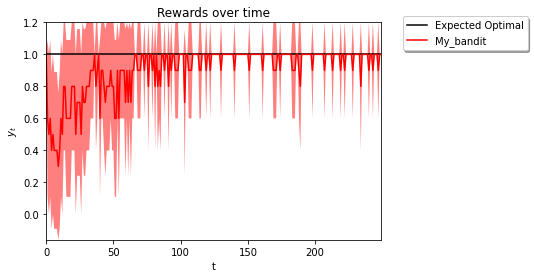

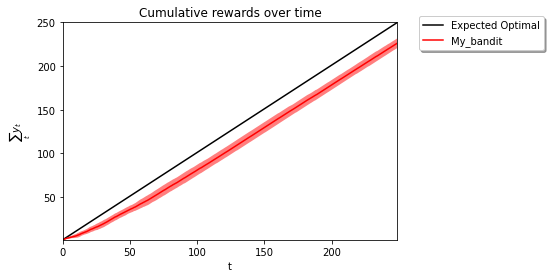

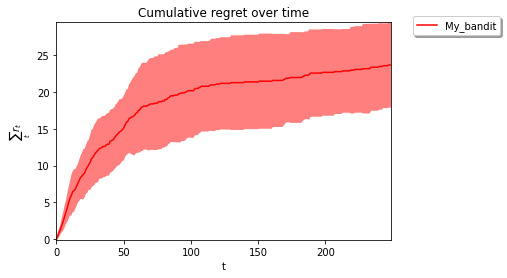

In [18]:
# Plotting
plot_rewards(observed_rewards, optimal_expected_rewards, n_bandit_interactions)
plot_cumrewards(observed_rewards, optimal_expected_rewards, n_bandit_interactions)
plot_cumregret(observed_rewards, optimal_expected_rewards, n_bandit_interactions)

### Bandit algorithm: UCB

In [19]:
# Time-varying beta function to use
# Update beta functions as per guidelines here:
#   https://arxiv.org/abs/0912.3995
#   https://papers.nips.cc/paper/2011/file/f3f1b7fc5a8779a9e618e1f23a7b7860-Paper.pdf
def beta_function(t,D=1,delta=0.01):
    return 2*torch.log(
                D*torch.pow(torch.tensor((t+1)*np.pi),2)/(6*delta)
            )

In [20]:
# UCB
ucb_algorithm={
    'name':'UCB',
    'beta':beta_function
}

In [21]:
# Instantiate bandit class
ucb_bandit=ContinuousArmBandit(
            arm_space=a,
            reward_model=bandit_reward_model,
            algorithm=ucb_algorithm
            )

# Multiple bandit realizations

In [22]:
# Number of interactions
n_bandit_interactions=250
# Optimal reward can be pre-computed
optimal_expected_rewards = true_bandit_environment.mean(
                            optimal_arm*torch.ones((1,n_bandit_interactions))
                        )
# Number of realizations
R=10
# Bandit arms and rewards for all realizations
played_arms=np.zeros((R,n_bandit_interactions,d_arms))
observed_rewards=np.zeros((R,n_bandit_interactions))

# Run realizations of bandits
for r in np.arange(R):
    print('************ r={}/{} **************'.format(r,R))
    # Restart bandit
    ucb_bandit.restart(n_bandit_interactions)
    # Execute bandit realization
    this_bandit = execute_bandit(ucb_bandit, true_bandit_environment, n_bandit_interactions)
    # Keep played arms and observed rewards
    played_arms[r]=this_bandit.played_arms
    observed_rewards[r]=this_bandit.observed_rewards
    print('**********************************'.format(r,R))

************ r=0/10 **************
Bandit interaction t=0
GP reward model training started...
	Iteration 2/100 with loss=0.915
	Iteration 3/100 with loss=0.873
	Iteration 4/100 with loss=0.843
	Iteration 5/100 with loss=0.824
	Iteration 6/100 with loss=0.816
	Iteration 7/100 with loss=0.814
GP reward model updated after 6 iterations with loss=0.814
Bandit interaction t=1
GP reward model training started...
	Iteration 2/100 with loss=1.216
	Iteration 3/100 with loss=1.141
	Iteration 4/100 with loss=1.079
	Iteration 5/100 with loss=1.028
	Iteration 6/100 with loss=0.990
	Iteration 7/100 with loss=0.963
	Iteration 8/100 with loss=0.948
	Iteration 9/100 with loss=0.942
GP reward model updated after 8 iterations with loss=0.942
Bandit interaction t=2
GP reward model training started...
	Iteration 2/100 with loss=0.951
	Iteration 3/100 with loss=0.926
	Iteration 4/100 with loss=0.913
	Iteration 5/100 with loss=0.912
GP reward model updated after 4 iterations with loss=0.912
Bandit interactio

GP reward model training started...
	Iteration 2/100 with loss=0.768
	Iteration 3/100 with loss=0.772
GP reward model updated after 2 iterations with loss=0.772
Bandit interaction t=43
GP reward model training started...
	Iteration 2/100 with loss=0.768
	Iteration 3/100 with loss=0.771
GP reward model updated after 2 iterations with loss=0.771
Bandit interaction t=44
GP reward model training started...
	Iteration 2/100 with loss=0.767
	Iteration 3/100 with loss=0.770
GP reward model updated after 2 iterations with loss=0.770
Bandit interaction t=45
GP reward model training started...
	Iteration 2/100 with loss=0.766
	Iteration 3/100 with loss=0.770
GP reward model updated after 2 iterations with loss=0.770
Bandit interaction t=46
GP reward model training started...
	Iteration 2/100 with loss=0.766
	Iteration 3/100 with loss=0.769
GP reward model updated after 2 iterations with loss=0.769
Bandit interaction t=47
GP reward model training started...
	Iteration 2/100 with loss=0.765
	Itera

/usr/local/lib/python3.8/dist-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


	Iteration 2/100 with loss=0.761
	Iteration 3/100 with loss=0.764
GP reward model updated after 2 iterations with loss=0.764
Bandit interaction t=57
GP reward model training started...
	Iteration 2/100 with loss=0.760
	Iteration 3/100 with loss=0.764
GP reward model updated after 2 iterations with loss=0.764
Bandit interaction t=58
GP reward model training started...
	Iteration 2/100 with loss=0.760
	Iteration 3/100 with loss=0.763
GP reward model updated after 2 iterations with loss=0.763
Bandit interaction t=59
GP reward model training started...
	Iteration 2/100 with loss=0.759
	Iteration 3/100 with loss=0.763
GP reward model updated after 2 iterations with loss=0.763
Bandit interaction t=60
GP reward model training started...
	Iteration 2/100 with loss=0.759
	Iteration 3/100 with loss=0.763
GP reward model updated after 2 iterations with loss=0.763
Bandit interaction t=61
GP reward model training started...
	Iteration 2/100 with loss=0.759
	Iteration 3/100 with loss=0.762
GP reward

	Iteration 3/100 with loss=0.804
GP reward model updated after 2 iterations with loss=0.804
Bandit interaction t=102
GP reward model training started...
	Iteration 2/100 with loss=0.799
	Iteration 3/100 with loss=0.803
GP reward model updated after 2 iterations with loss=0.803
Bandit interaction t=103
GP reward model training started...
	Iteration 2/100 with loss=0.799
	Iteration 3/100 with loss=0.802
GP reward model updated after 2 iterations with loss=0.802
Bandit interaction t=104
GP reward model training started...
	Iteration 2/100 with loss=0.798
	Iteration 3/100 with loss=0.802
GP reward model updated after 2 iterations with loss=0.802
Bandit interaction t=105
GP reward model training started...
	Iteration 2/100 with loss=0.798
	Iteration 3/100 with loss=0.801
GP reward model updated after 2 iterations with loss=0.801
Bandit interaction t=106
GP reward model training started...
	Iteration 2/100 with loss=0.797
	Iteration 3/100 with loss=0.801
GP reward model updated after 2 itera

GP reward model training started...
	Iteration 2/100 with loss=0.794
	Iteration 3/100 with loss=0.798
GP reward model updated after 2 iterations with loss=0.798
Bandit interaction t=147
GP reward model training started...
	Iteration 2/100 with loss=0.794
	Iteration 3/100 with loss=0.798
GP reward model updated after 2 iterations with loss=0.798
Bandit interaction t=148
GP reward model training started...
	Iteration 2/100 with loss=0.794
	Iteration 3/100 with loss=0.797
GP reward model updated after 2 iterations with loss=0.797
Bandit interaction t=149
GP reward model training started...
	Iteration 2/100 with loss=0.793
	Iteration 3/100 with loss=0.797
GP reward model updated after 2 iterations with loss=0.797
Bandit interaction t=150
GP reward model training started...
	Iteration 2/100 with loss=0.793
	Iteration 3/100 with loss=0.796
GP reward model updated after 2 iterations with loss=0.796
Bandit interaction t=151
GP reward model training started...
	Iteration 2/100 with loss=0.793
	

	Iteration 2/100 with loss=0.788
	Iteration 3/100 with loss=0.792
GP reward model updated after 2 iterations with loss=0.792
Bandit interaction t=191
GP reward model training started...
	Iteration 2/100 with loss=0.788
	Iteration 3/100 with loss=0.792
GP reward model updated after 2 iterations with loss=0.792
Bandit interaction t=192
GP reward model training started...
	Iteration 2/100 with loss=0.788
	Iteration 3/100 with loss=0.791
GP reward model updated after 2 iterations with loss=0.791
Bandit interaction t=193
GP reward model training started...
	Iteration 2/100 with loss=0.788
	Iteration 3/100 with loss=0.791
GP reward model updated after 2 iterations with loss=0.791
Bandit interaction t=194
GP reward model training started...
	Iteration 2/100 with loss=0.787
	Iteration 3/100 with loss=0.791
GP reward model updated after 2 iterations with loss=0.791
Bandit interaction t=195
GP reward model training started...
	Iteration 2/100 with loss=0.791
	Iteration 3/100 with loss=0.793
GP r

GP reward model training started...
	Iteration 2/100 with loss=0.795
	Iteration 3/100 with loss=0.798
GP reward model updated after 2 iterations with loss=0.798
Bandit interaction t=236
GP reward model training started...
	Iteration 2/100 with loss=0.795
	Iteration 3/100 with loss=0.798
GP reward model updated after 2 iterations with loss=0.798
Bandit interaction t=237
GP reward model training started...
	Iteration 2/100 with loss=0.794
	Iteration 3/100 with loss=0.798
GP reward model updated after 2 iterations with loss=0.798
Bandit interaction t=238
GP reward model training started...
	Iteration 2/100 with loss=0.794
	Iteration 3/100 with loss=0.797
GP reward model updated after 2 iterations with loss=0.797
Bandit interaction t=239
GP reward model training started...
	Iteration 2/100 with loss=0.794
	Iteration 3/100 with loss=0.797
GP reward model updated after 2 iterations with loss=0.797
Bandit interaction t=240
GP reward model training started...
	Iteration 2/100 with loss=0.794
	

GP reward model training started...
	Iteration 2/100 with loss=0.869
	Iteration 3/100 with loss=0.871
GP reward model updated after 2 iterations with loss=0.871
Bandit interaction t=29
GP reward model training started...
	Iteration 2/100 with loss=0.865
	Iteration 3/100 with loss=0.869
GP reward model updated after 2 iterations with loss=0.869
Bandit interaction t=30
GP reward model training started...
	Iteration 2/100 with loss=0.863
	Iteration 3/100 with loss=0.865
GP reward model updated after 2 iterations with loss=0.865
Bandit interaction t=31
GP reward model training started...
	Iteration 2/100 with loss=0.859
	Iteration 3/100 with loss=0.863
GP reward model updated after 2 iterations with loss=0.863
Bandit interaction t=32
GP reward model training started...
	Iteration 2/100 with loss=0.857
	Iteration 3/100 with loss=0.860
GP reward model updated after 2 iterations with loss=0.860
Bandit interaction t=33
GP reward model training started...
	Iteration 2/100 with loss=0.854
	Itera

	Iteration 2/100 with loss=0.827
	Iteration 3/100 with loss=0.831
GP reward model updated after 2 iterations with loss=0.831
Bandit interaction t=74
GP reward model training started...
	Iteration 2/100 with loss=0.827
	Iteration 3/100 with loss=0.830
GP reward model updated after 2 iterations with loss=0.830
Bandit interaction t=75
GP reward model training started...
	Iteration 2/100 with loss=0.825
	Iteration 3/100 with loss=0.829
GP reward model updated after 2 iterations with loss=0.829
Bandit interaction t=76
GP reward model training started...
	Iteration 2/100 with loss=0.825
	Iteration 3/100 with loss=0.828
GP reward model updated after 2 iterations with loss=0.828
Bandit interaction t=77
GP reward model training started...
	Iteration 2/100 with loss=0.824
	Iteration 3/100 with loss=0.827
GP reward model updated after 2 iterations with loss=0.827
Bandit interaction t=78
GP reward model training started...
	Iteration 2/100 with loss=0.823
	Iteration 3/100 with loss=0.826
GP reward

GP reward model training started...
	Iteration 2/100 with loss=0.825
	Iteration 3/100 with loss=0.828
GP reward model updated after 2 iterations with loss=0.828
Bandit interaction t=119
GP reward model training started...
	Iteration 2/100 with loss=0.829
	Iteration 3/100 with loss=0.831
GP reward model updated after 2 iterations with loss=0.831
Bandit interaction t=120
GP reward model training started...
	Iteration 2/100 with loss=0.828
	Iteration 3/100 with loss=0.830
GP reward model updated after 2 iterations with loss=0.830
Bandit interaction t=121
GP reward model training started...
	Iteration 2/100 with loss=0.832
	Iteration 3/100 with loss=0.834
GP reward model updated after 2 iterations with loss=0.834
Bandit interaction t=122
GP reward model training started...
	Iteration 2/100 with loss=0.831
	Iteration 3/100 with loss=0.833
GP reward model updated after 2 iterations with loss=0.833
Bandit interaction t=123
GP reward model training started...
	Iteration 2/100 with loss=0.834
	

GP reward model training started...
	Iteration 2/100 with loss=0.838
	Iteration 3/100 with loss=0.842
GP reward model updated after 2 iterations with loss=0.842
Bandit interaction t=164
GP reward model training started...
	Iteration 2/100 with loss=0.838
	Iteration 3/100 with loss=0.841
GP reward model updated after 2 iterations with loss=0.841
Bandit interaction t=165
GP reward model training started...
	Iteration 2/100 with loss=0.837
	Iteration 3/100 with loss=0.841
GP reward model updated after 2 iterations with loss=0.841
Bandit interaction t=166
GP reward model training started...
	Iteration 2/100 with loss=0.837
	Iteration 3/100 with loss=0.840
GP reward model updated after 2 iterations with loss=0.840
Bandit interaction t=167
GP reward model training started...
	Iteration 2/100 with loss=0.836
	Iteration 3/100 with loss=0.840
GP reward model updated after 2 iterations with loss=0.840
Bandit interaction t=168
GP reward model training started...
	Iteration 2/100 with loss=0.836
	

	Iteration 2/100 with loss=0.835
	Iteration 3/100 with loss=0.838
GP reward model updated after 2 iterations with loss=0.838
Bandit interaction t=208
GP reward model training started...
	Iteration 2/100 with loss=0.835
	Iteration 3/100 with loss=0.838
GP reward model updated after 2 iterations with loss=0.838
Bandit interaction t=209
GP reward model training started...
	Iteration 2/100 with loss=0.834
	Iteration 3/100 with loss=0.838
GP reward model updated after 2 iterations with loss=0.838
Bandit interaction t=210
GP reward model training started...
	Iteration 2/100 with loss=0.834
	Iteration 3/100 with loss=0.837
GP reward model updated after 2 iterations with loss=0.837
Bandit interaction t=211
GP reward model training started...
	Iteration 2/100 with loss=0.836
	Iteration 3/100 with loss=0.839
GP reward model updated after 2 iterations with loss=0.839
Bandit interaction t=212
GP reward model training started...
	Iteration 2/100 with loss=0.835
	Iteration 3/100 with loss=0.838
GP r

	Iteration 5/100 with loss=0.973
	Iteration 6/100 with loss=0.941
	Iteration 7/100 with loss=0.923
	Iteration 8/100 with loss=0.916
GP reward model updated after 7 iterations with loss=0.916
Bandit interaction t=2
GP reward model training started...
	Iteration 2/100 with loss=0.932
	Iteration 3/100 with loss=0.907
	Iteration 4/100 with loss=0.897
	Iteration 5/100 with loss=0.898
GP reward model updated after 4 iterations with loss=0.898
Bandit interaction t=3
GP reward model training started...
	Iteration 2/100 with loss=0.969
	Iteration 3/100 with loss=0.937
	Iteration 4/100 with loss=0.920
	Iteration 5/100 with loss=0.916
GP reward model updated after 4 iterations with loss=0.916
Bandit interaction t=4
GP reward model training started...
	Iteration 2/100 with loss=0.909
	Iteration 3/100 with loss=0.914
GP reward model updated after 2 iterations with loss=0.914
Bandit interaction t=5
GP reward model training started...
	Iteration 2/100 with loss=0.927
	Iteration 3/100 with loss=0.916


	Iteration 3/100 with loss=0.872
GP reward model updated after 2 iterations with loss=0.872
Bandit interaction t=45
GP reward model training started...
	Iteration 2/100 with loss=0.867
	Iteration 3/100 with loss=0.871
GP reward model updated after 2 iterations with loss=0.871
Bandit interaction t=46
GP reward model training started...
	Iteration 2/100 with loss=0.866
	Iteration 3/100 with loss=0.869
GP reward model updated after 2 iterations with loss=0.869
Bandit interaction t=47
GP reward model training started...
	Iteration 2/100 with loss=0.864
	Iteration 3/100 with loss=0.867
GP reward model updated after 2 iterations with loss=0.867
Bandit interaction t=48
GP reward model training started...
	Iteration 2/100 with loss=0.862
	Iteration 3/100 with loss=0.865
GP reward model updated after 2 iterations with loss=0.865
Bandit interaction t=49
GP reward model training started...
	Iteration 2/100 with loss=0.860
	Iteration 3/100 with loss=0.864
GP reward model updated after 2 iterations

	Iteration 3/100 with loss=0.876
GP reward model updated after 2 iterations with loss=0.876
Bandit interaction t=90
GP reward model training started...
	Iteration 2/100 with loss=0.873
	Iteration 3/100 with loss=0.875
GP reward model updated after 2 iterations with loss=0.875
Bandit interaction t=91
GP reward model training started...
	Iteration 2/100 with loss=0.872
	Iteration 3/100 with loss=0.875
GP reward model updated after 2 iterations with loss=0.875
Bandit interaction t=92
GP reward model training started...
	Iteration 2/100 with loss=0.874
	Iteration 3/100 with loss=0.879
GP reward model updated after 2 iterations with loss=0.879
Bandit interaction t=93
GP reward model training started...
	Iteration 2/100 with loss=0.873
	Iteration 3/100 with loss=0.877
GP reward model updated after 2 iterations with loss=0.877
Bandit interaction t=94
GP reward model training started...
	Iteration 2/100 with loss=0.872
	Iteration 3/100 with loss=0.876
GP reward model updated after 2 iterations

GP reward model training started...
	Iteration 2/100 with loss=0.889
	Iteration 3/100 with loss=0.893
GP reward model updated after 2 iterations with loss=0.893
Bandit interaction t=135
GP reward model training started...
	Iteration 2/100 with loss=0.888
	Iteration 3/100 with loss=0.892
GP reward model updated after 2 iterations with loss=0.892
Bandit interaction t=136
GP reward model training started...
	Iteration 2/100 with loss=0.888
	Iteration 3/100 with loss=0.891
GP reward model updated after 2 iterations with loss=0.891
Bandit interaction t=137
GP reward model training started...
	Iteration 2/100 with loss=0.889
	Iteration 3/100 with loss=0.892
GP reward model updated after 2 iterations with loss=0.892
Bandit interaction t=138
GP reward model training started...
	Iteration 2/100 with loss=0.889
	Iteration 3/100 with loss=0.891
GP reward model updated after 2 iterations with loss=0.891
Bandit interaction t=139
GP reward model training started...
	Iteration 2/100 with loss=0.890
	

	Iteration 3/100 with loss=0.892
GP reward model updated after 2 iterations with loss=0.892
Bandit interaction t=179
GP reward model training started...
	Iteration 2/100 with loss=0.889
	Iteration 3/100 with loss=0.892
GP reward model updated after 2 iterations with loss=0.892
Bandit interaction t=180
GP reward model training started...
	Iteration 2/100 with loss=0.889
	Iteration 3/100 with loss=0.892
GP reward model updated after 2 iterations with loss=0.892
Bandit interaction t=181
GP reward model training started...
	Iteration 2/100 with loss=0.888
	Iteration 3/100 with loss=0.892
GP reward model updated after 2 iterations with loss=0.892
Bandit interaction t=182
GP reward model training started...
	Iteration 2/100 with loss=0.888
	Iteration 3/100 with loss=0.891
GP reward model updated after 2 iterations with loss=0.891
Bandit interaction t=183
GP reward model training started...
	Iteration 2/100 with loss=0.887
	Iteration 3/100 with loss=0.891
GP reward model updated after 2 itera

GP reward model training started...
	Iteration 2/100 with loss=0.886
	Iteration 3/100 with loss=0.889
GP reward model updated after 2 iterations with loss=0.889
Bandit interaction t=224
GP reward model training started...
	Iteration 2/100 with loss=0.886
	Iteration 3/100 with loss=0.889
GP reward model updated after 2 iterations with loss=0.889
Bandit interaction t=225
GP reward model training started...
	Iteration 2/100 with loss=0.885
	Iteration 3/100 with loss=0.889
GP reward model updated after 2 iterations with loss=0.889
Bandit interaction t=226
GP reward model training started...
	Iteration 2/100 with loss=0.885
	Iteration 3/100 with loss=0.888
GP reward model updated after 2 iterations with loss=0.888
Bandit interaction t=227
GP reward model training started...
	Iteration 2/100 with loss=0.886
	Iteration 3/100 with loss=0.889
GP reward model updated after 2 iterations with loss=0.889
Bandit interaction t=228
GP reward model training started...
	Iteration 2/100 with loss=0.886
	

	Iteration 2/100 with loss=0.917
	Iteration 3/100 with loss=0.909
GP reward model updated after 2 iterations with loss=0.909
Bandit interaction t=15
GP reward model training started...
	Iteration 2/100 with loss=0.914
	Iteration 3/100 with loss=0.917
GP reward model updated after 2 iterations with loss=0.917
Bandit interaction t=16
GP reward model training started...
	Iteration 2/100 with loss=0.918
	Iteration 3/100 with loss=0.917
GP reward model updated after 2 iterations with loss=0.917
Bandit interaction t=17
GP reward model training started...
	Iteration 2/100 with loss=0.919
	Iteration 3/100 with loss=0.914
GP reward model updated after 2 iterations with loss=0.914
Bandit interaction t=18
GP reward model training started...
	Iteration 2/100 with loss=0.922
	Iteration 3/100 with loss=0.916
GP reward model updated after 2 iterations with loss=0.916
Bandit interaction t=19
GP reward model training started...
	Iteration 2/100 with loss=0.917
	Iteration 3/100 with loss=0.919
GP reward

GP reward model training started...
	Iteration 2/100 with loss=0.918
	Iteration 3/100 with loss=0.918
GP reward model updated after 2 iterations with loss=0.918
Bandit interaction t=62
GP reward model training started...
	Iteration 2/100 with loss=0.918
	Iteration 3/100 with loss=0.918
GP reward model updated after 2 iterations with loss=0.918
Bandit interaction t=63
GP reward model training started...
	Iteration 2/100 with loss=0.917
	Iteration 3/100 with loss=0.919
GP reward model updated after 2 iterations with loss=0.919
Bandit interaction t=64
GP reward model training started...
	Iteration 2/100 with loss=0.917
	Iteration 3/100 with loss=0.918
GP reward model updated after 2 iterations with loss=0.918
Bandit interaction t=65
GP reward model training started...
	Iteration 2/100 with loss=0.916
	Iteration 3/100 with loss=0.919
GP reward model updated after 2 iterations with loss=0.919
Bandit interaction t=66
GP reward model training started...
	Iteration 2/100 with loss=0.916
	Itera

	Iteration 3/100 with loss=0.920
GP reward model updated after 2 iterations with loss=0.920
Bandit interaction t=106
GP reward model training started...
	Iteration 2/100 with loss=0.917
	Iteration 3/100 with loss=0.920
GP reward model updated after 2 iterations with loss=0.920
Bandit interaction t=107
GP reward model training started...
	Iteration 2/100 with loss=0.916
	Iteration 3/100 with loss=0.920
GP reward model updated after 2 iterations with loss=0.920
Bandit interaction t=108
GP reward model training started...
	Iteration 2/100 with loss=0.916
	Iteration 3/100 with loss=0.919
GP reward model updated after 2 iterations with loss=0.919
Bandit interaction t=109
GP reward model training started...
	Iteration 2/100 with loss=0.917
	Iteration 3/100 with loss=0.919
GP reward model updated after 2 iterations with loss=0.919
Bandit interaction t=110
GP reward model training started...
	Iteration 2/100 with loss=0.916
	Iteration 3/100 with loss=0.920
GP reward model updated after 2 itera

GP reward model training started...
	Iteration 2/100 with loss=0.916
	Iteration 3/100 with loss=0.920
GP reward model updated after 2 iterations with loss=0.920
Bandit interaction t=151
GP reward model training started...
	Iteration 2/100 with loss=0.916
	Iteration 3/100 with loss=0.920
GP reward model updated after 2 iterations with loss=0.920
Bandit interaction t=152
GP reward model training started...
	Iteration 2/100 with loss=0.916
	Iteration 3/100 with loss=0.920
GP reward model updated after 2 iterations with loss=0.920
Bandit interaction t=153
GP reward model training started...
	Iteration 2/100 with loss=0.916
	Iteration 3/100 with loss=0.920
GP reward model updated after 2 iterations with loss=0.920
Bandit interaction t=154
GP reward model training started...
	Iteration 2/100 with loss=0.916
	Iteration 3/100 with loss=0.920
GP reward model updated after 2 iterations with loss=0.920
Bandit interaction t=155
GP reward model training started...
	Iteration 2/100 with loss=0.916
	

	Iteration 3/100 with loss=0.914
GP reward model updated after 2 iterations with loss=0.914
Bandit interaction t=195
GP reward model training started...
	Iteration 2/100 with loss=0.910
	Iteration 3/100 with loss=0.913
GP reward model updated after 2 iterations with loss=0.913
Bandit interaction t=196
GP reward model training started...
	Iteration 2/100 with loss=0.909
	Iteration 3/100 with loss=0.913
GP reward model updated after 2 iterations with loss=0.913
Bandit interaction t=197
GP reward model training started...
	Iteration 2/100 with loss=0.909
	Iteration 3/100 with loss=0.913
GP reward model updated after 2 iterations with loss=0.913
Bandit interaction t=198
GP reward model training started...
	Iteration 2/100 with loss=0.909
	Iteration 3/100 with loss=0.913
GP reward model updated after 2 iterations with loss=0.913
Bandit interaction t=199
GP reward model training started...
	Iteration 2/100 with loss=0.909
	Iteration 3/100 with loss=0.913
GP reward model updated after 2 itera

GP reward model training started...
	Iteration 2/100 with loss=0.902
	Iteration 3/100 with loss=0.905
GP reward model updated after 2 iterations with loss=0.905
Bandit interaction t=240
GP reward model training started...
	Iteration 2/100 with loss=0.902
	Iteration 3/100 with loss=0.905
GP reward model updated after 2 iterations with loss=0.905
Bandit interaction t=241
GP reward model training started...
	Iteration 2/100 with loss=0.902
	Iteration 3/100 with loss=0.905
GP reward model updated after 2 iterations with loss=0.905
Bandit interaction t=242
GP reward model training started...
	Iteration 2/100 with loss=0.901
	Iteration 3/100 with loss=0.905
GP reward model updated after 2 iterations with loss=0.905
Bandit interaction t=243
GP reward model training started...
	Iteration 2/100 with loss=0.901
	Iteration 3/100 with loss=0.904
GP reward model updated after 2 iterations with loss=0.904
Bandit interaction t=244
GP reward model training started...
	Iteration 2/100 with loss=0.901
	

GP reward model training started...
	Iteration 2/100 with loss=0.906
	Iteration 3/100 with loss=0.908
GP reward model updated after 2 iterations with loss=0.908
Bandit interaction t=32
GP reward model training started...
	Iteration 2/100 with loss=0.903
	Iteration 3/100 with loss=0.907
GP reward model updated after 2 iterations with loss=0.907
Bandit interaction t=33
GP reward model training started...
	Iteration 2/100 with loss=0.901
	Iteration 3/100 with loss=0.904
GP reward model updated after 2 iterations with loss=0.904
Bandit interaction t=34
GP reward model training started...
	Iteration 2/100 with loss=0.906
	Iteration 3/100 with loss=0.906
GP reward model updated after 2 iterations with loss=0.906
Bandit interaction t=35
GP reward model training started...
	Iteration 2/100 with loss=0.904
	Iteration 3/100 with loss=0.904
GP reward model updated after 2 iterations with loss=0.904
Bandit interaction t=36
GP reward model training started...
	Iteration 2/100 with loss=0.901
	Itera

	Iteration 3/100 with loss=0.894
GP reward model updated after 2 iterations with loss=0.894
Bandit interaction t=77
GP reward model training started...
	Iteration 2/100 with loss=0.890
	Iteration 3/100 with loss=0.893
GP reward model updated after 2 iterations with loss=0.893
Bandit interaction t=78
GP reward model training started...
	Iteration 2/100 with loss=0.889
	Iteration 3/100 with loss=0.892
GP reward model updated after 2 iterations with loss=0.892
Bandit interaction t=79
GP reward model training started...
	Iteration 2/100 with loss=0.888
	Iteration 3/100 with loss=0.891
GP reward model updated after 2 iterations with loss=0.891
Bandit interaction t=80
GP reward model training started...
	Iteration 2/100 with loss=0.887
	Iteration 3/100 with loss=0.890
GP reward model updated after 2 iterations with loss=0.890
Bandit interaction t=81
GP reward model training started...
	Iteration 2/100 with loss=0.886
	Iteration 3/100 with loss=0.889
GP reward model updated after 2 iterations

	Iteration 3/100 with loss=0.882
GP reward model updated after 2 iterations with loss=0.882
Bandit interaction t=122
GP reward model training started...
	Iteration 2/100 with loss=0.881
	Iteration 3/100 with loss=0.883
GP reward model updated after 2 iterations with loss=0.883
Bandit interaction t=123
GP reward model training started...
	Iteration 2/100 with loss=0.880
	Iteration 3/100 with loss=0.883
GP reward model updated after 2 iterations with loss=0.883
Bandit interaction t=124
GP reward model training started...
	Iteration 2/100 with loss=0.879
	Iteration 3/100 with loss=0.882
GP reward model updated after 2 iterations with loss=0.882
Bandit interaction t=125
GP reward model training started...
	Iteration 2/100 with loss=0.878
	Iteration 3/100 with loss=0.882
GP reward model updated after 2 iterations with loss=0.882
Bandit interaction t=126
GP reward model training started...
	Iteration 2/100 with loss=0.878
	Iteration 3/100 with loss=0.881
GP reward model updated after 2 itera

	Iteration 2/100 with loss=0.863
	Iteration 3/100 with loss=0.867
GP reward model updated after 2 iterations with loss=0.867
Bandit interaction t=167
GP reward model training started...
	Iteration 2/100 with loss=0.863
	Iteration 3/100 with loss=0.866
GP reward model updated after 2 iterations with loss=0.866
Bandit interaction t=168
GP reward model training started...
	Iteration 2/100 with loss=0.862
	Iteration 3/100 with loss=0.866
GP reward model updated after 2 iterations with loss=0.866
Bandit interaction t=169
GP reward model training started...
	Iteration 2/100 with loss=0.861
	Iteration 3/100 with loss=0.865
GP reward model updated after 2 iterations with loss=0.865
Bandit interaction t=170
GP reward model training started...
	Iteration 2/100 with loss=0.861
	Iteration 3/100 with loss=0.864
GP reward model updated after 2 iterations with loss=0.864
Bandit interaction t=171
GP reward model training started...
	Iteration 2/100 with loss=0.860
	Iteration 3/100 with loss=0.864
GP r

	Iteration 3/100 with loss=0.848
GP reward model updated after 2 iterations with loss=0.848
Bandit interaction t=211
GP reward model training started...
	Iteration 2/100 with loss=0.847
	Iteration 3/100 with loss=0.851
GP reward model updated after 2 iterations with loss=0.851
Bandit interaction t=212
GP reward model training started...
	Iteration 2/100 with loss=0.846
	Iteration 3/100 with loss=0.850
GP reward model updated after 2 iterations with loss=0.850
Bandit interaction t=213
GP reward model training started...
	Iteration 2/100 with loss=0.846
	Iteration 3/100 with loss=0.849
GP reward model updated after 2 iterations with loss=0.849
Bandit interaction t=214
GP reward model training started...
	Iteration 2/100 with loss=0.845
	Iteration 3/100 with loss=0.849
GP reward model updated after 2 iterations with loss=0.849
Bandit interaction t=215
GP reward model training started...
	Iteration 2/100 with loss=0.845
	Iteration 3/100 with loss=0.848
GP reward model updated after 2 itera

	Iteration 4/100 with loss=0.920
	Iteration 5/100 with loss=0.916
GP reward model updated after 4 iterations with loss=0.916
Bandit interaction t=4
GP reward model training started...
	Iteration 2/100 with loss=0.909
	Iteration 3/100 with loss=0.914
GP reward model updated after 2 iterations with loss=0.914
Bandit interaction t=5
GP reward model training started...
	Iteration 2/100 with loss=0.927
	Iteration 3/100 with loss=0.916
	Iteration 4/100 with loss=0.918
GP reward model updated after 3 iterations with loss=0.918
Bandit interaction t=6
GP reward model training started...
	Iteration 2/100 with loss=0.913
	Iteration 3/100 with loss=0.918
GP reward model updated after 2 iterations with loss=0.918
Bandit interaction t=7
GP reward model training started...
	Iteration 2/100 with loss=0.909
	Iteration 3/100 with loss=0.905
GP reward model updated after 2 iterations with loss=0.905
Bandit interaction t=8
GP reward model training started...
	Iteration 2/100 with loss=0.896
	Iteration 3/1

	Iteration 2/100 with loss=0.855
	Iteration 3/100 with loss=0.859
GP reward model updated after 2 iterations with loss=0.859
Bandit interaction t=48
GP reward model training started...
	Iteration 2/100 with loss=0.854
	Iteration 3/100 with loss=0.857
GP reward model updated after 2 iterations with loss=0.857
Bandit interaction t=49
GP reward model training started...
	Iteration 2/100 with loss=0.852
	Iteration 3/100 with loss=0.855
GP reward model updated after 2 iterations with loss=0.855
Bandit interaction t=50
GP reward model training started...
	Iteration 2/100 with loss=0.858
	Iteration 3/100 with loss=0.864
GP reward model updated after 2 iterations with loss=0.864
Bandit interaction t=51
GP reward model training started...
	Iteration 2/100 with loss=0.856
	Iteration 3/100 with loss=0.861
GP reward model updated after 2 iterations with loss=0.861
Bandit interaction t=52
GP reward model training started...
	Iteration 2/100 with loss=0.855
	Iteration 3/100 with loss=0.858
GP reward

	Iteration 2/100 with loss=0.823
	Iteration 3/100 with loss=0.826
GP reward model updated after 2 iterations with loss=0.826
Bandit interaction t=93
GP reward model training started...
	Iteration 2/100 with loss=0.822
	Iteration 3/100 with loss=0.826
GP reward model updated after 2 iterations with loss=0.826
Bandit interaction t=94
GP reward model training started...
	Iteration 2/100 with loss=0.821
	Iteration 3/100 with loss=0.825
GP reward model updated after 2 iterations with loss=0.825
Bandit interaction t=95
GP reward model training started...
	Iteration 2/100 with loss=0.827
	Iteration 3/100 with loss=0.829
GP reward model updated after 2 iterations with loss=0.829
Bandit interaction t=96
GP reward model training started...
	Iteration 2/100 with loss=0.826
	Iteration 3/100 with loss=0.828
GP reward model updated after 2 iterations with loss=0.828
Bandit interaction t=97
GP reward model training started...
	Iteration 2/100 with loss=0.825
	Iteration 3/100 with loss=0.828
GP reward

GP reward model training started...
	Iteration 2/100 with loss=0.826
	Iteration 3/100 with loss=0.828
GP reward model updated after 2 iterations with loss=0.828
Bandit interaction t=138
GP reward model training started...
	Iteration 2/100 with loss=0.829
	Iteration 3/100 with loss=0.832
GP reward model updated after 2 iterations with loss=0.832
Bandit interaction t=139
GP reward model training started...
	Iteration 2/100 with loss=0.828
	Iteration 3/100 with loss=0.832
GP reward model updated after 2 iterations with loss=0.832
Bandit interaction t=140
GP reward model training started...
	Iteration 2/100 with loss=0.828
	Iteration 3/100 with loss=0.831
GP reward model updated after 2 iterations with loss=0.831
Bandit interaction t=141
GP reward model training started...
	Iteration 2/100 with loss=0.831
	Iteration 3/100 with loss=0.834
GP reward model updated after 2 iterations with loss=0.834
Bandit interaction t=142
GP reward model training started...
	Iteration 2/100 with loss=0.830
	

	Iteration 3/100 with loss=0.820
GP reward model updated after 2 iterations with loss=0.820
Bandit interaction t=182
GP reward model training started...
	Iteration 2/100 with loss=0.815
	Iteration 3/100 with loss=0.819
GP reward model updated after 2 iterations with loss=0.819
Bandit interaction t=183
GP reward model training started...
	Iteration 2/100 with loss=0.818
	Iteration 3/100 with loss=0.821
GP reward model updated after 2 iterations with loss=0.821
Bandit interaction t=184
GP reward model training started...
	Iteration 2/100 with loss=0.818
	Iteration 3/100 with loss=0.821
GP reward model updated after 2 iterations with loss=0.821
Bandit interaction t=185
GP reward model training started...
	Iteration 2/100 with loss=0.820
	Iteration 3/100 with loss=0.823
GP reward model updated after 2 iterations with loss=0.823
Bandit interaction t=186
GP reward model training started...
	Iteration 2/100 with loss=0.820
	Iteration 3/100 with loss=0.823
GP reward model updated after 2 itera

GP reward model training started...
	Iteration 2/100 with loss=0.821
	Iteration 3/100 with loss=0.825
GP reward model updated after 2 iterations with loss=0.825
Bandit interaction t=227
GP reward model training started...
	Iteration 2/100 with loss=0.823
	Iteration 3/100 with loss=0.826
GP reward model updated after 2 iterations with loss=0.826
Bandit interaction t=228
GP reward model training started...
	Iteration 2/100 with loss=0.823
	Iteration 3/100 with loss=0.826
GP reward model updated after 2 iterations with loss=0.826
Bandit interaction t=229
GP reward model training started...
	Iteration 2/100 with loss=0.823
	Iteration 3/100 with loss=0.826
GP reward model updated after 2 iterations with loss=0.826
Bandit interaction t=230
GP reward model training started...
	Iteration 2/100 with loss=0.822
	Iteration 3/100 with loss=0.826
GP reward model updated after 2 iterations with loss=0.826
Bandit interaction t=231
GP reward model training started...
	Iteration 2/100 with loss=0.824
	

	Iteration 3/100 with loss=0.832
GP reward model updated after 2 iterations with loss=0.832
Bandit interaction t=20
GP reward model training started...
	Iteration 2/100 with loss=0.825
	Iteration 3/100 with loss=0.827
GP reward model updated after 2 iterations with loss=0.827
Bandit interaction t=21
GP reward model training started...
	Iteration 2/100 with loss=0.821
	Iteration 3/100 with loss=0.825
GP reward model updated after 2 iterations with loss=0.825
Bandit interaction t=22
GP reward model training started...
	Iteration 2/100 with loss=0.818
	Iteration 3/100 with loss=0.821
GP reward model updated after 2 iterations with loss=0.821
Bandit interaction t=23
GP reward model training started...
	Iteration 2/100 with loss=0.839
	Iteration 3/100 with loss=0.837
GP reward model updated after 2 iterations with loss=0.837
Bandit interaction t=24
GP reward model training started...
	Iteration 2/100 with loss=0.836
	Iteration 3/100 with loss=0.834
GP reward model updated after 2 iterations

GP reward model training started...
	Iteration 2/100 with loss=0.821
	Iteration 3/100 with loss=0.825
GP reward model updated after 2 iterations with loss=0.825
Bandit interaction t=66
GP reward model training started...
	Iteration 2/100 with loss=0.820
	Iteration 3/100 with loss=0.823
GP reward model updated after 2 iterations with loss=0.823
Bandit interaction t=67
GP reward model training started...
	Iteration 2/100 with loss=0.819
	Iteration 3/100 with loss=0.823
GP reward model updated after 2 iterations with loss=0.823
Bandit interaction t=68
GP reward model training started...
	Iteration 2/100 with loss=0.818
	Iteration 3/100 with loss=0.821
GP reward model updated after 2 iterations with loss=0.821
Bandit interaction t=69
GP reward model training started...
	Iteration 2/100 with loss=0.817
	Iteration 3/100 with loss=0.821
GP reward model updated after 2 iterations with loss=0.821
Bandit interaction t=70
GP reward model training started...
	Iteration 2/100 with loss=0.823
	Itera

	Iteration 3/100 with loss=0.810
GP reward model updated after 2 iterations with loss=0.810
Bandit interaction t=110
GP reward model training started...
	Iteration 2/100 with loss=0.806
	Iteration 3/100 with loss=0.809
GP reward model updated after 2 iterations with loss=0.809
Bandit interaction t=111
GP reward model training started...
	Iteration 2/100 with loss=0.805
	Iteration 3/100 with loss=0.809
GP reward model updated after 2 iterations with loss=0.809
Bandit interaction t=112
GP reward model training started...
	Iteration 2/100 with loss=0.805
	Iteration 3/100 with loss=0.808
GP reward model updated after 2 iterations with loss=0.808
Bandit interaction t=113
GP reward model training started...
	Iteration 2/100 with loss=0.804
	Iteration 3/100 with loss=0.808
GP reward model updated after 2 iterations with loss=0.808
Bandit interaction t=114
GP reward model training started...
	Iteration 2/100 with loss=0.804
	Iteration 3/100 with loss=0.807
GP reward model updated after 2 itera

	Iteration 2/100 with loss=0.791
	Iteration 3/100 with loss=0.796
GP reward model updated after 2 iterations with loss=0.796
Bandit interaction t=155
GP reward model training started...
	Iteration 2/100 with loss=0.791
	Iteration 3/100 with loss=0.795
GP reward model updated after 2 iterations with loss=0.795
Bandit interaction t=156
GP reward model training started...
	Iteration 2/100 with loss=0.791
	Iteration 3/100 with loss=0.795
GP reward model updated after 2 iterations with loss=0.795
Bandit interaction t=157
GP reward model training started...
	Iteration 2/100 with loss=0.791
	Iteration 3/100 with loss=0.794
GP reward model updated after 2 iterations with loss=0.794
Bandit interaction t=158
GP reward model training started...
	Iteration 2/100 with loss=0.790
	Iteration 3/100 with loss=0.794
GP reward model updated after 2 iterations with loss=0.794
Bandit interaction t=159
GP reward model training started...
	Iteration 2/100 with loss=0.790
	Iteration 3/100 with loss=0.794
GP r

	Iteration 3/100 with loss=0.799
GP reward model updated after 2 iterations with loss=0.799
Bandit interaction t=199
GP reward model training started...
	Iteration 2/100 with loss=0.795
	Iteration 3/100 with loss=0.799
GP reward model updated after 2 iterations with loss=0.799
Bandit interaction t=200
GP reward model training started...
	Iteration 2/100 with loss=0.795
	Iteration 3/100 with loss=0.798
GP reward model updated after 2 iterations with loss=0.798
Bandit interaction t=201
GP reward model training started...
	Iteration 2/100 with loss=0.795
	Iteration 3/100 with loss=0.798
GP reward model updated after 2 iterations with loss=0.798
Bandit interaction t=202
GP reward model training started...
	Iteration 2/100 with loss=0.795
	Iteration 3/100 with loss=0.798
GP reward model updated after 2 iterations with loss=0.798
Bandit interaction t=203
GP reward model training started...
	Iteration 2/100 with loss=0.797
	Iteration 3/100 with loss=0.800
GP reward model updated after 2 itera

GP reward model training started...
	Iteration 2/100 with loss=0.807
	Iteration 3/100 with loss=0.811
GP reward model updated after 2 iterations with loss=0.811
Bandit interaction t=244
GP reward model training started...
	Iteration 2/100 with loss=0.807
	Iteration 3/100 with loss=0.810
GP reward model updated after 2 iterations with loss=0.810
Bandit interaction t=245
GP reward model training started...
	Iteration 2/100 with loss=0.807
	Iteration 3/100 with loss=0.810
GP reward model updated after 2 iterations with loss=0.810
Bandit interaction t=246
GP reward model training started...
	Iteration 2/100 with loss=0.806
	Iteration 3/100 with loss=0.810
GP reward model updated after 2 iterations with loss=0.810
Bandit interaction t=247
GP reward model training started...
	Iteration 2/100 with loss=0.806
	Iteration 3/100 with loss=0.810
GP reward model updated after 2 iterations with loss=0.810
Bandit interaction t=248
GP reward model training started...
	Iteration 2/100 with loss=0.806
	

	Iteration 3/100 with loss=0.858
GP reward model updated after 2 iterations with loss=0.858
Bandit interaction t=37
GP reward model training started...
	Iteration 2/100 with loss=0.858
	Iteration 3/100 with loss=0.857
GP reward model updated after 2 iterations with loss=0.857
Bandit interaction t=38
GP reward model training started...
	Iteration 2/100 with loss=0.856
	Iteration 3/100 with loss=0.855
GP reward model updated after 2 iterations with loss=0.855
Bandit interaction t=39
GP reward model training started...
	Iteration 2/100 with loss=0.853
	Iteration 3/100 with loss=0.853
GP reward model updated after 2 iterations with loss=0.853
Bandit interaction t=40
GP reward model training started...
	Iteration 2/100 with loss=0.860
	Iteration 3/100 with loss=0.864
GP reward model updated after 2 iterations with loss=0.864
Bandit interaction t=41
GP reward model training started...
	Iteration 2/100 with loss=0.857
	Iteration 3/100 with loss=0.862
GP reward model updated after 2 iterations

	Iteration 2/100 with loss=0.849
	Iteration 3/100 with loss=0.853
GP reward model updated after 2 iterations with loss=0.853
Bandit interaction t=82
GP reward model training started...
	Iteration 2/100 with loss=0.849
	Iteration 3/100 with loss=0.852
GP reward model updated after 2 iterations with loss=0.852
Bandit interaction t=83
GP reward model training started...
	Iteration 2/100 with loss=0.847
	Iteration 3/100 with loss=0.851
GP reward model updated after 2 iterations with loss=0.851
Bandit interaction t=84
GP reward model training started...
	Iteration 2/100 with loss=0.847
	Iteration 3/100 with loss=0.850
GP reward model updated after 2 iterations with loss=0.850
Bandit interaction t=85
GP reward model training started...
	Iteration 2/100 with loss=0.845
	Iteration 3/100 with loss=0.849
GP reward model updated after 2 iterations with loss=0.849
Bandit interaction t=86
GP reward model training started...
	Iteration 2/100 with loss=0.845
	Iteration 3/100 with loss=0.848
GP reward

GP reward model training started...
	Iteration 2/100 with loss=0.847
	Iteration 3/100 with loss=0.850
GP reward model updated after 2 iterations with loss=0.850
Bandit interaction t=127
GP reward model training started...
	Iteration 2/100 with loss=0.850
	Iteration 3/100 with loss=0.852
GP reward model updated after 2 iterations with loss=0.852
Bandit interaction t=128
GP reward model training started...
	Iteration 2/100 with loss=0.849
	Iteration 3/100 with loss=0.852
GP reward model updated after 2 iterations with loss=0.852
Bandit interaction t=129
GP reward model training started...
	Iteration 2/100 with loss=0.852
	Iteration 3/100 with loss=0.854
GP reward model updated after 2 iterations with loss=0.854
Bandit interaction t=130
GP reward model training started...
	Iteration 2/100 with loss=0.851
	Iteration 3/100 with loss=0.854
GP reward model updated after 2 iterations with loss=0.854
Bandit interaction t=131
GP reward model training started...
	Iteration 2/100 with loss=0.850
	

	Iteration 2/100 with loss=0.841
	Iteration 3/100 with loss=0.844
GP reward model updated after 2 iterations with loss=0.844
Bandit interaction t=171
GP reward model training started...
	Iteration 2/100 with loss=0.840
	Iteration 3/100 with loss=0.844
GP reward model updated after 2 iterations with loss=0.844
Bandit interaction t=172
GP reward model training started...
	Iteration 2/100 with loss=0.840
	Iteration 3/100 with loss=0.843
GP reward model updated after 2 iterations with loss=0.843
Bandit interaction t=173
GP reward model training started...
	Iteration 2/100 with loss=0.839
	Iteration 3/100 with loss=0.843
GP reward model updated after 2 iterations with loss=0.843
Bandit interaction t=174
GP reward model training started...
	Iteration 2/100 with loss=0.839
	Iteration 3/100 with loss=0.842
GP reward model updated after 2 iterations with loss=0.842
Bandit interaction t=175
GP reward model training started...
	Iteration 2/100 with loss=0.838
	Iteration 3/100 with loss=0.842
GP r

	Iteration 3/100 with loss=0.838
GP reward model updated after 2 iterations with loss=0.838
Bandit interaction t=215
GP reward model training started...
	Iteration 2/100 with loss=0.834
	Iteration 3/100 with loss=0.838
GP reward model updated after 2 iterations with loss=0.838
Bandit interaction t=216
GP reward model training started...
	Iteration 2/100 with loss=0.834
	Iteration 3/100 with loss=0.837
GP reward model updated after 2 iterations with loss=0.837
Bandit interaction t=217
GP reward model training started...
	Iteration 2/100 with loss=0.833
	Iteration 3/100 with loss=0.837
GP reward model updated after 2 iterations with loss=0.837
Bandit interaction t=218
GP reward model training started...
	Iteration 2/100 with loss=0.833
	Iteration 3/100 with loss=0.836
GP reward model updated after 2 iterations with loss=0.836
Bandit interaction t=219
GP reward model training started...
	Iteration 2/100 with loss=0.833
	Iteration 3/100 with loss=0.836
GP reward model updated after 2 itera

	Iteration 2/100 with loss=0.887
	Iteration 3/100 with loss=0.884
GP reward model updated after 2 iterations with loss=0.884
Bandit interaction t=7
GP reward model training started...
	Iteration 2/100 with loss=0.872
	Iteration 3/100 with loss=0.875
GP reward model updated after 2 iterations with loss=0.875
Bandit interaction t=8
GP reward model training started...
	Iteration 2/100 with loss=0.898
	Iteration 3/100 with loss=0.897
GP reward model updated after 2 iterations with loss=0.897
Bandit interaction t=9
GP reward model training started...
	Iteration 2/100 with loss=0.892
	Iteration 3/100 with loss=0.887
GP reward model updated after 2 iterations with loss=0.887
Bandit interaction t=10
GP reward model training started...
	Iteration 2/100 with loss=0.880
	Iteration 3/100 with loss=0.881
GP reward model updated after 2 iterations with loss=0.881
Bandit interaction t=11
GP reward model training started...
	Iteration 2/100 with loss=0.873
	Iteration 3/100 with loss=0.872
GP reward mo

	Iteration 2/100 with loss=0.810
	Iteration 3/100 with loss=0.813
GP reward model updated after 2 iterations with loss=0.813
Bandit interaction t=52
GP reward model training started...
	Iteration 2/100 with loss=0.809
	Iteration 3/100 with loss=0.812
GP reward model updated after 2 iterations with loss=0.812
Bandit interaction t=53
GP reward model training started...
	Iteration 2/100 with loss=0.807
	Iteration 3/100 with loss=0.811
GP reward model updated after 2 iterations with loss=0.811
Bandit interaction t=54
GP reward model training started...
	Iteration 2/100 with loss=0.806
	Iteration 3/100 with loss=0.810
GP reward model updated after 2 iterations with loss=0.810
Bandit interaction t=55
GP reward model training started...
	Iteration 2/100 with loss=0.805
	Iteration 3/100 with loss=0.809
GP reward model updated after 2 iterations with loss=0.809
Bandit interaction t=56
GP reward model training started...
	Iteration 2/100 with loss=0.804
	Iteration 3/100 with loss=0.807
GP reward

GP reward model training started...
	Iteration 2/100 with loss=0.784
	Iteration 3/100 with loss=0.788
GP reward model updated after 2 iterations with loss=0.788
Bandit interaction t=98
GP reward model training started...
	Iteration 2/100 with loss=0.784
	Iteration 3/100 with loss=0.787
GP reward model updated after 2 iterations with loss=0.787
Bandit interaction t=99
GP reward model training started...
	Iteration 2/100 with loss=0.783
	Iteration 3/100 with loss=0.787
GP reward model updated after 2 iterations with loss=0.787
Bandit interaction t=100
GP reward model training started...
	Iteration 2/100 with loss=0.783
	Iteration 3/100 with loss=0.786
GP reward model updated after 2 iterations with loss=0.786
Bandit interaction t=101
GP reward model training started...
	Iteration 2/100 with loss=0.782
	Iteration 3/100 with loss=0.786
GP reward model updated after 2 iterations with loss=0.786
Bandit interaction t=102
GP reward model training started...
	Iteration 2/100 with loss=0.782
	It

	Iteration 2/100 with loss=0.783
	Iteration 3/100 with loss=0.787
GP reward model updated after 2 iterations with loss=0.787
Bandit interaction t=142
GP reward model training started...
	Iteration 2/100 with loss=0.783
	Iteration 3/100 with loss=0.787
GP reward model updated after 2 iterations with loss=0.787
Bandit interaction t=143
GP reward model training started...
	Iteration 2/100 with loss=0.783
	Iteration 3/100 with loss=0.786
GP reward model updated after 2 iterations with loss=0.786
Bandit interaction t=144
GP reward model training started...
	Iteration 2/100 with loss=0.783
	Iteration 3/100 with loss=0.786
GP reward model updated after 2 iterations with loss=0.786
Bandit interaction t=145
GP reward model training started...
	Iteration 2/100 with loss=0.782
	Iteration 3/100 with loss=0.786
GP reward model updated after 2 iterations with loss=0.786
Bandit interaction t=146
GP reward model training started...
	Iteration 2/100 with loss=0.782
	Iteration 3/100 with loss=0.785
GP r

	Iteration 3/100 with loss=0.796
GP reward model updated after 2 iterations with loss=0.796
Bandit interaction t=186
GP reward model training started...
	Iteration 2/100 with loss=0.793
	Iteration 3/100 with loss=0.796
GP reward model updated after 2 iterations with loss=0.796
Bandit interaction t=187
GP reward model training started...
	Iteration 2/100 with loss=0.792
	Iteration 3/100 with loss=0.796
GP reward model updated after 2 iterations with loss=0.796
Bandit interaction t=188
GP reward model training started...
	Iteration 2/100 with loss=0.792
	Iteration 3/100 with loss=0.796
GP reward model updated after 2 iterations with loss=0.796
Bandit interaction t=189
GP reward model training started...
	Iteration 2/100 with loss=0.795
	Iteration 3/100 with loss=0.798
GP reward model updated after 2 iterations with loss=0.798
Bandit interaction t=190
GP reward model training started...
	Iteration 2/100 with loss=0.798
	Iteration 3/100 with loss=0.802
GP reward model updated after 2 itera

GP reward model training started...
	Iteration 2/100 with loss=0.798
	Iteration 3/100 with loss=0.802
GP reward model updated after 2 iterations with loss=0.802
Bandit interaction t=231
GP reward model training started...
	Iteration 2/100 with loss=0.798
	Iteration 3/100 with loss=0.802
GP reward model updated after 2 iterations with loss=0.802
Bandit interaction t=232
GP reward model training started...
	Iteration 2/100 with loss=0.800
	Iteration 3/100 with loss=0.804
GP reward model updated after 2 iterations with loss=0.804
Bandit interaction t=233
GP reward model training started...
	Iteration 2/100 with loss=0.800
	Iteration 3/100 with loss=0.804
GP reward model updated after 2 iterations with loss=0.804
Bandit interaction t=234
GP reward model training started...
	Iteration 2/100 with loss=0.800
	Iteration 3/100 with loss=0.803
GP reward model updated after 2 iterations with loss=0.803
Bandit interaction t=235
GP reward model training started...
	Iteration 2/100 with loss=0.802
	

GP reward model training started...
	Iteration 2/100 with loss=0.907
	Iteration 3/100 with loss=0.909
GP reward model updated after 2 iterations with loss=0.909
Bandit interaction t=21
GP reward model training started...
	Iteration 2/100 with loss=0.910
	Iteration 3/100 with loss=0.917
GP reward model updated after 2 iterations with loss=0.917
Bandit interaction t=22
GP reward model training started...
	Iteration 2/100 with loss=0.908
	Iteration 3/100 with loss=0.914
GP reward model updated after 2 iterations with loss=0.914
Bandit interaction t=23
GP reward model training started...
	Iteration 2/100 with loss=0.906
	Iteration 3/100 with loss=0.907
GP reward model updated after 2 iterations with loss=0.907
Bandit interaction t=24
GP reward model training started...
	Iteration 2/100 with loss=0.902
	Iteration 3/100 with loss=0.907
GP reward model updated after 2 iterations with loss=0.907
Bandit interaction t=25
GP reward model training started...
	Iteration 2/100 with loss=0.900
	Itera

	Iteration 3/100 with loss=0.916
GP reward model updated after 2 iterations with loss=0.916
Bandit interaction t=65
GP reward model training started...
	Iteration 2/100 with loss=0.914
	Iteration 3/100 with loss=0.918
GP reward model updated after 2 iterations with loss=0.918
Bandit interaction t=66
GP reward model training started...
	Iteration 2/100 with loss=0.915
	Iteration 3/100 with loss=0.917
GP reward model updated after 2 iterations with loss=0.917
Bandit interaction t=67
GP reward model training started...
	Iteration 2/100 with loss=0.915
	Iteration 3/100 with loss=0.919
GP reward model updated after 2 iterations with loss=0.919
Bandit interaction t=68
GP reward model training started...
	Iteration 2/100 with loss=0.914
	Iteration 3/100 with loss=0.919
GP reward model updated after 2 iterations with loss=0.919
Bandit interaction t=69
GP reward model training started...
	Iteration 2/100 with loss=0.915
	Iteration 3/100 with loss=0.920
GP reward model updated after 2 iterations

GP reward model training started...
	Iteration 2/100 with loss=0.917
	Iteration 3/100 with loss=0.919
GP reward model updated after 2 iterations with loss=0.919
Bandit interaction t=111
GP reward model training started...
	Iteration 2/100 with loss=0.917
	Iteration 3/100 with loss=0.919
GP reward model updated after 2 iterations with loss=0.919
Bandit interaction t=112
GP reward model training started...
	Iteration 2/100 with loss=0.917
	Iteration 3/100 with loss=0.919
GP reward model updated after 2 iterations with loss=0.919
Bandit interaction t=113
GP reward model training started...
	Iteration 2/100 with loss=0.917
	Iteration 3/100 with loss=0.920
GP reward model updated after 2 iterations with loss=0.920
Bandit interaction t=114
GP reward model training started...
	Iteration 2/100 with loss=0.917
	Iteration 3/100 with loss=0.919
GP reward model updated after 2 iterations with loss=0.919
Bandit interaction t=115
GP reward model training started...
	Iteration 2/100 with loss=0.916
	

	Iteration 2/100 with loss=0.914
	Iteration 3/100 with loss=0.917
GP reward model updated after 2 iterations with loss=0.917
Bandit interaction t=155
GP reward model training started...
	Iteration 2/100 with loss=0.914
	Iteration 3/100 with loss=0.917
GP reward model updated after 2 iterations with loss=0.917
Bandit interaction t=156
GP reward model training started...
	Iteration 2/100 with loss=0.914
	Iteration 3/100 with loss=0.918
GP reward model updated after 2 iterations with loss=0.918
Bandit interaction t=157
GP reward model training started...
	Iteration 2/100 with loss=0.914
	Iteration 3/100 with loss=0.918
GP reward model updated after 2 iterations with loss=0.918
Bandit interaction t=158
GP reward model training started...
	Iteration 2/100 with loss=0.914
	Iteration 3/100 with loss=0.918
GP reward model updated after 2 iterations with loss=0.918
Bandit interaction t=159
GP reward model training started...
	Iteration 2/100 with loss=0.914
	Iteration 3/100 with loss=0.918
GP r

	Iteration 3/100 with loss=0.917
GP reward model updated after 2 iterations with loss=0.917
Bandit interaction t=199
GP reward model training started...
	Iteration 2/100 with loss=0.913
	Iteration 3/100 with loss=0.917
GP reward model updated after 2 iterations with loss=0.917
Bandit interaction t=200
GP reward model training started...
	Iteration 2/100 with loss=0.914
	Iteration 3/100 with loss=0.918
GP reward model updated after 2 iterations with loss=0.918
Bandit interaction t=201
GP reward model training started...
	Iteration 2/100 with loss=0.914
	Iteration 3/100 with loss=0.917
GP reward model updated after 2 iterations with loss=0.917
Bandit interaction t=202
GP reward model training started...
	Iteration 2/100 with loss=0.914
	Iteration 3/100 with loss=0.917
GP reward model updated after 2 iterations with loss=0.917
Bandit interaction t=203
GP reward model training started...
	Iteration 2/100 with loss=0.914
	Iteration 3/100 with loss=0.917
GP reward model updated after 2 itera

	Iteration 2/100 with loss=0.912
	Iteration 3/100 with loss=0.915
GP reward model updated after 2 iterations with loss=0.915
Bandit interaction t=244
GP reward model training started...
	Iteration 2/100 with loss=0.912
	Iteration 3/100 with loss=0.916
GP reward model updated after 2 iterations with loss=0.916
Bandit interaction t=245
GP reward model training started...
	Iteration 2/100 with loss=0.912
	Iteration 3/100 with loss=0.916
GP reward model updated after 2 iterations with loss=0.916
Bandit interaction t=246
GP reward model training started...
	Iteration 2/100 with loss=0.912
	Iteration 3/100 with loss=0.915
GP reward model updated after 2 iterations with loss=0.915
Bandit interaction t=247
GP reward model training started...
	Iteration 2/100 with loss=0.912
	Iteration 3/100 with loss=0.915
GP reward model updated after 2 iterations with loss=0.915
Bandit interaction t=248
GP reward model training started...
	Iteration 2/100 with loss=0.912
	Iteration 3/100 with loss=0.915
GP r

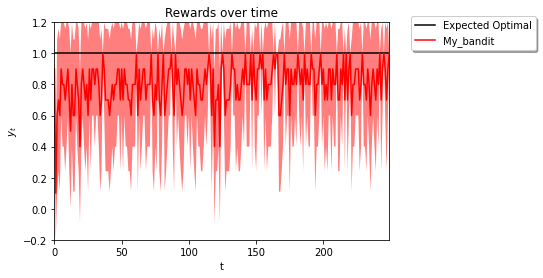

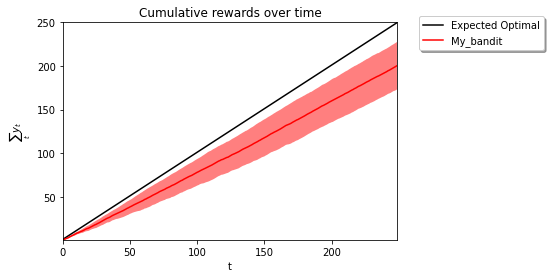

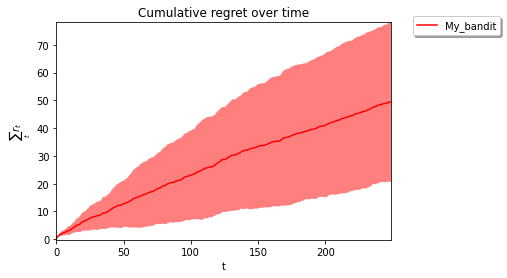

In [23]:
# Plotting
plot_rewards(observed_rewards, optimal_expected_rewards, n_bandit_interactions)
plot_cumrewards(observed_rewards, optimal_expected_rewards, n_bandit_interactions)
plot_cumregret(observed_rewards, optimal_expected_rewards, n_bandit_interactions)